In [1]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

In [2]:
# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

In [156]:
def boxplot(df, x, y, color=None, alpha=0.1, marker="<"):
    
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est("median", errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def rangeplot(df, x, y, color=None, alpha=0.1):

    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est("median", errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

# Bike Sharing Demand
Forecast use of a city bikeshare system

- 2011년 1월부터 2012년 12월까지의 자전거 대여 데이터: [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv)

- 자전거 대여 수에 영향을 주는 요인들을 살펴보고, 이를 예측하는 모델을 세워보세요.
 
 - “시간대별” 대여수를 이용하거나 앞서 다룬 것처럼 “날짜별” 대여수를 이용
 - 여러 모형을 세워보고 residuals을 분석
- 자전거의 수와 같이 “count”에 대한 값을 예측하는 경우 보통 count의 분포가 Poisson 분포를 보이는 경향이 있기에 분포를 함께 고려하는 generalized linear model을 이용하는 것이 더 적절할 수 있음.

- 간단히 count값을 (N)^1/2
나 log(N+1)
로 변환하여 분포를 간단히 변형해서 분석할 수도 있음.

---

시간단위로 기록을 했고
시즌정보가 있음 > 날짜가 시즌이 정해져있기 때문에 날짜구분해주기 
holiday
workingday
weather 자전거는 날씨에 민감하다
count는 총 빌린 횟수 

2년치 데이터

한시간마다 나타나있음
24시간으로 끊어서 하루의 데이터를 만들 수있음
날씨는 최빈값? 평균 정도로 고민해보기 

count는 특별한 분포를 보여서 모형의 결합시키기 어려운데
포아송 분포를 결합해서 보여야함.> generalized linear

해당값을 쓰지않아도 되는데 카운트 데이터를 루트를 씌우거나 로그를 사용해서 적절하게 값을 눌러줄 수 있음.
어떤걸 쓸지는 데이터에 따라 다름. 비교해볼것.

In [233]:
bikeshare = pd.read_csv("train.csv", parse_dates=["datetime"])
bikeshare.head() # 24개씩 =하루 

datetime  season  holiday  workingday  weather  temp  atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.39   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.39   

   humidity  windspeed  casual  registered  count  
0        81       0.00       3          13     16  
1        80       0.00       8          32     40  
2        80       0.00       5          27     32  
3        75       0.00       3          10     13  
4        75       0.00       0           1      1

In [234]:
bikeshare["year"] = bikeshare["datetime"].dt.year
bikeshare["date"] = bikeshare["datetime"].dt.date
bikeshare["day"] = bikeshare["datetime"].dt.day_of_year
bikeshare["time"] = bikeshare["datetime"].dt.time

## a hack to get the day of the year
#bikeshare["datetime"].apply(lambda x: x.replace(year=2011)) # pandas.Timestamp.replace

In [311]:
bikeshare["datetime"].apply(lambda x: x.replace(year=2011)) # pandas.Timestamp.replace

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
                ...        
10883   2011-12-19 21:00:00
10884   2011-12-19 22:00:00
10885   2011-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [312]:
bikeshare

datetime  season  holiday  workingday  weather  temp  atemp  \
0     2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1     2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2     2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
...                   ...     ...      ...         ...      ...   ...    ...   
10883 2012-12-19 21:00:00       4        0           1        1 13.94  15.91   
10884 2012-12-19 22:00:00       4        0           1        1 13.94  17.43   
10885 2012-12-19 23:00:00       4        0           1        1 13.12  16.66   

       humidity  windspeed  casual  registered  count  year        date  day  \
0            81       0.00       3          13     16  2011  2011-01-01    1   
1            80       0.00       8          32     40  2011  2011-01-01    1   
2            80       0.00       5          27     32  2011  2011-01-01    1   
...         ...        ...     ...         ...    ...   ...         ...  ...   
10883        61      15.00       4         164    168  2012  2012-12-19  354   
10884        61       6.00      12         117    129  2012  2012-12-19  354   
10885        66       9.00       4          84     88  2012  2012-12-19  354   

           time seasonv weatherv  most_common_weather  
0      00:00:00  spring    clear                    1  
1      01:00:00  spring    clear                    1  
2      02:00:00  spring    clear                    1  
...         ...     ...      ...                  ...  
10883  21:00:00  winter    clear                    1  
10884  22:00:00  winter    clear                    1  
10885  23:00:00  winter    clear                    1  

[10886 rows x 19 columns]

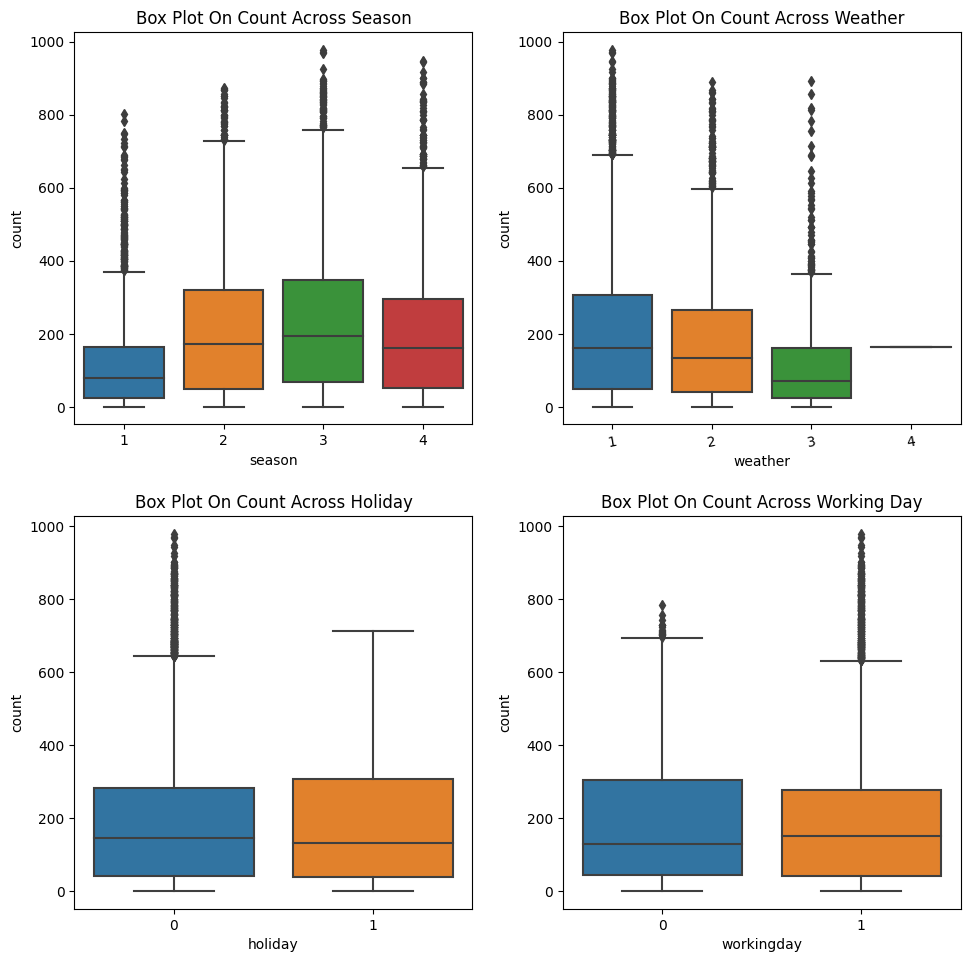

In [437]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=bikeshare, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=bikeshare, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=bikeshare, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=bikeshare, ax=axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0, 1].tick_params('x', labelrotation=10) # 10도 회전

# 시간대별

In [235]:
times = bikeshare.groupby('time')["count"].mean().reset_index(name="n")
times

time      n
0   00:00:00  55.14
1   01:00:00  33.86
2   02:00:00  22.90
..       ...    ...
21  21:00:00 173.37
22  22:00:00 133.58
23  23:00:00  89.51

[24 rows x 2 columns]

In [236]:
times["time"] = times["time"].astype(str)
times["t"] = times["time"].str[:2]
times

time      n   t
0   00:00:00  55.14  00
1   01:00:00  33.86  01
2   02:00:00  22.90  02
..       ...    ...  ..
21  21:00:00 173.37  21
22  22:00:00 133.58  22
23  23:00:00  89.51  23

[24 rows x 3 columns]

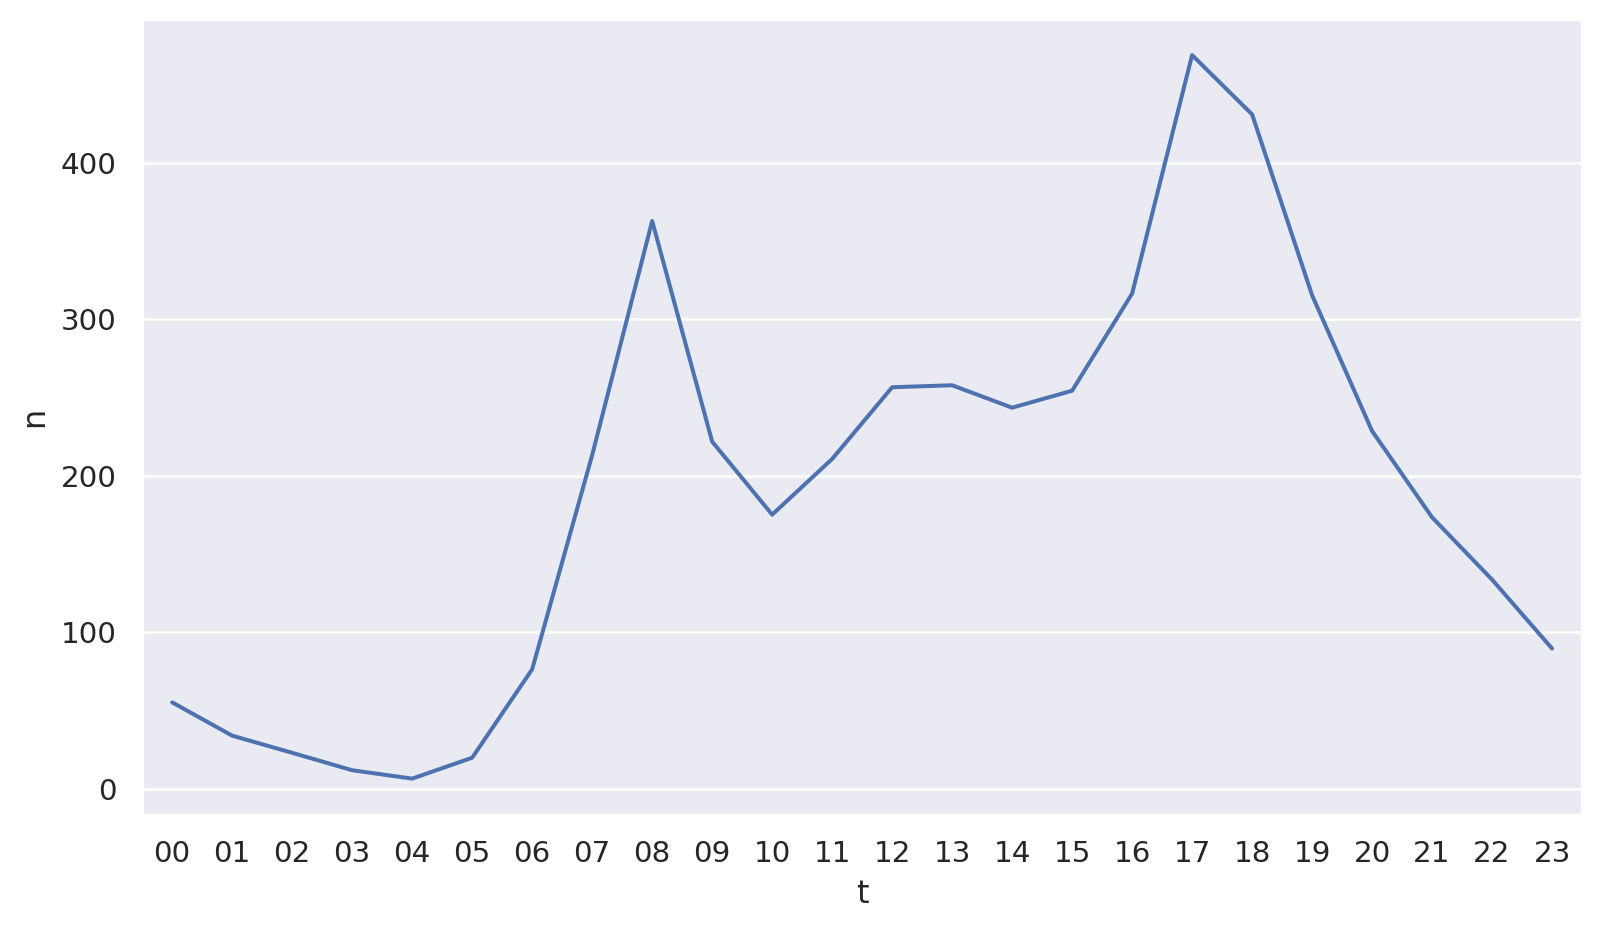

In [237]:
(
    so.Plot(times, x='t', y='n')
    .add(so.Line())
    .layout(size=(8.5, 5))
)

출퇴근시간대에 이용률이 높은것같음

In [245]:
times=times.assign(
    ln=lambda x: np.log2(x.n)
)

In [246]:
times.sort_values(by='ln', ascending=False)

time      n   t   ln
17  17:00:00 468.77  17 8.87
18  18:00:00 430.86  18 8.75
8   08:00:00 362.77  08 8.50
..       ...    ...  ..  ...
5   05:00:00  19.77  05 4.31
3   03:00:00  11.76  03 3.56
4   04:00:00   6.41  04 2.68

[24 rows x 4 columns]

In [449]:
from statsmodels.formula.api import ols 
# 또는 import statsmodels.formula.api as smf

mod1 = ols("ln ~ t", data=times).fit()

In [450]:
t = pd.Categorical(
    ["00", "01", "02", "03", "04", "05", "06","07", "08", "09", "10", "11", "12","13", "14", "15", "16","17", "18", "19", "20", "21", "22", "23"],
    categories=["00", "01", "02", "03", "04", "05", "06","07", "08", "09", "10", "11", "12","13", "14", "15", "16","17", "18", "19", "20", "21", "22", "23"],
)

grid = pd.DataFrame({"t": t})

In [451]:
grid["pred"] = mod1.predict(grid)
grid

#times.groupby("t")["n"].mean()

t  pred
0   00  5.78
1   01  5.08
2   02  4.52
..  ..   ...
21  21  7.44
22  22  7.06
23  23  6.48

[24 rows x 2 columns]

In [452]:
times.groupby("t")["ln"].mean()

t
00   5.78
01   5.08
02   4.52
     ... 
21   7.44
22   7.06
23   6.48
Name: ln, Length: 24, dtype: float64

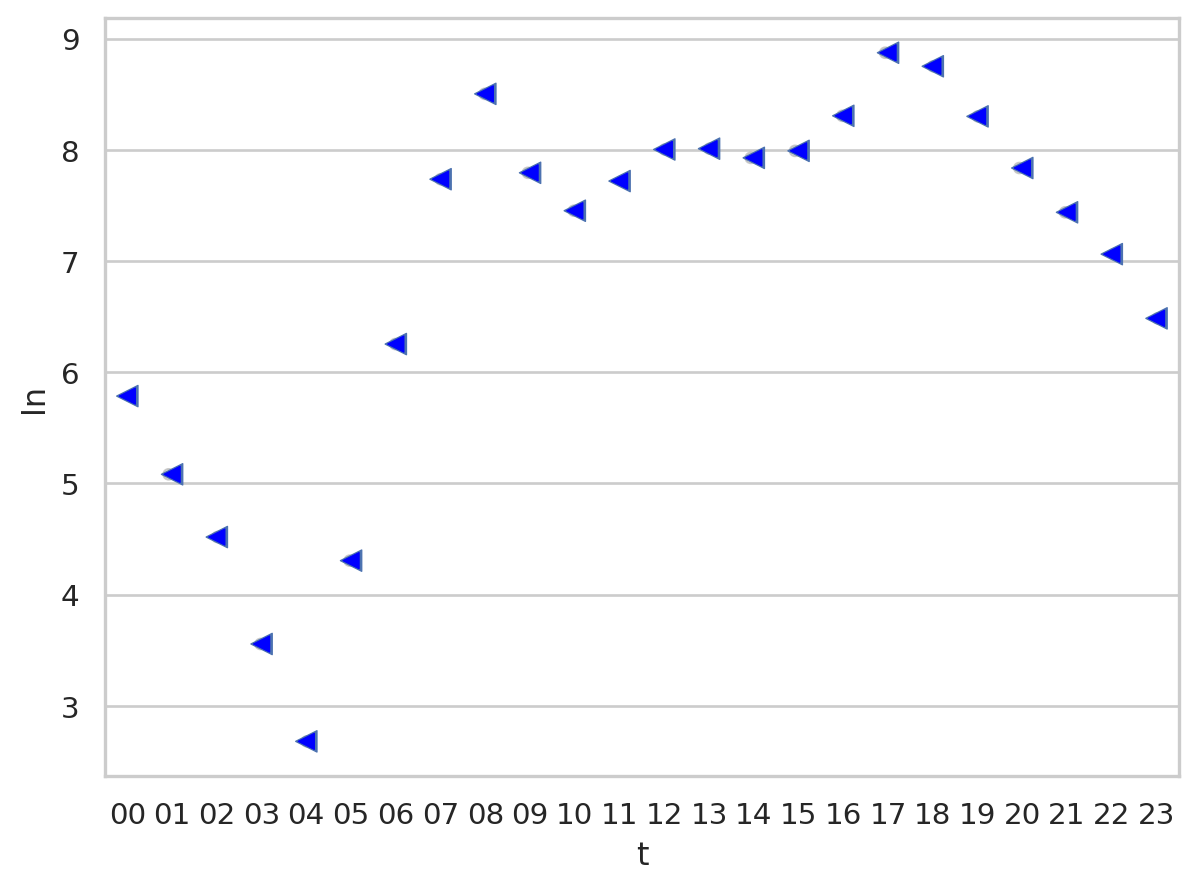

In [453]:
(
    boxplot(times, "t", "ln", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.t, y=grid.pred)
)

rseiduals

In [252]:
# add a column of residuals from mod
times["resid"] = mod.resid

In [255]:
times.sort_values(by='resid', ascending=False)

time      n   t   ln  resid
5   05:00:00  19.77  05 4.31  -0.00
19  19:00:00 315.28  19 8.30  -0.00
3   03:00:00  11.76  03 3.56  -0.00
..       ...    ...  ..  ...    ...
7   07:00:00 213.12  07 7.74  -0.00
6   06:00:00  76.26  06 6.25  -0.00
0   00:00:00  55.14  00 5.78  -0.00

[24 rows x 5 columns]

In [258]:
times.query('resid !=-0.00')

time      n   t   ln  resid
0   00:00:00  55.14  00 5.78  -0.00
1   01:00:00  33.86  01 5.08  -0.00
2   02:00:00  22.90  02 4.52  -0.00
..       ...    ...  ..  ...    ...
21  21:00:00 173.37  21 7.44  -0.00
22  22:00:00 133.58  22 7.06  -0.00
23  23:00:00  89.51  23 6.48  -0.00

[24 rows x 5 columns]

선형 모델이 안맞는듯?

# 요일별

In [259]:
daily = bikeshare.groupby("date")['count'].sum().reset_index(name="n")
daily

date     n
0    2011-01-01   985
1    2011-01-02   801
2    2011-01-03  1349
..          ...   ...
453  2012-12-17  4585
454  2012-12-18  5557
455  2012-12-19  5267

[456 rows x 2 columns]

In [317]:
daily=daily.assign(
    ln=lambda x: np.log2(x.n)
)
daily

date     n wday    resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat -3734.97    1   -2465.24   -2535.98       1  spring   
1   2011-01-02   801  Sun -3525.45    2   -2463.26   -2525.92       1  spring   
2   2011-01-03  1349  Mon -3194.02    3   -2461.25   -2515.87       1  spring   
..         ...   ...  ...      ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon    41.98  352    -404.22    -420.37       4  winter   
454 2012-12-18  5557  Tue  1064.92  353    -409.75    -429.99       4  winter   
455 2012-12-19  5267  Wed   771.22  354    -415.25    -439.61       4  winter   

     most_common_weather weatherv    ln  
0                      1    clear  9.94  
1                      2     mist  9.65  
2                      1    clear 10.40  
..                   ...      ...   ...  
453                    2     mist 12.16  
454                    1    clear 12.44  
455                    1    clear 12.36  

[456 rows x 12 columns]

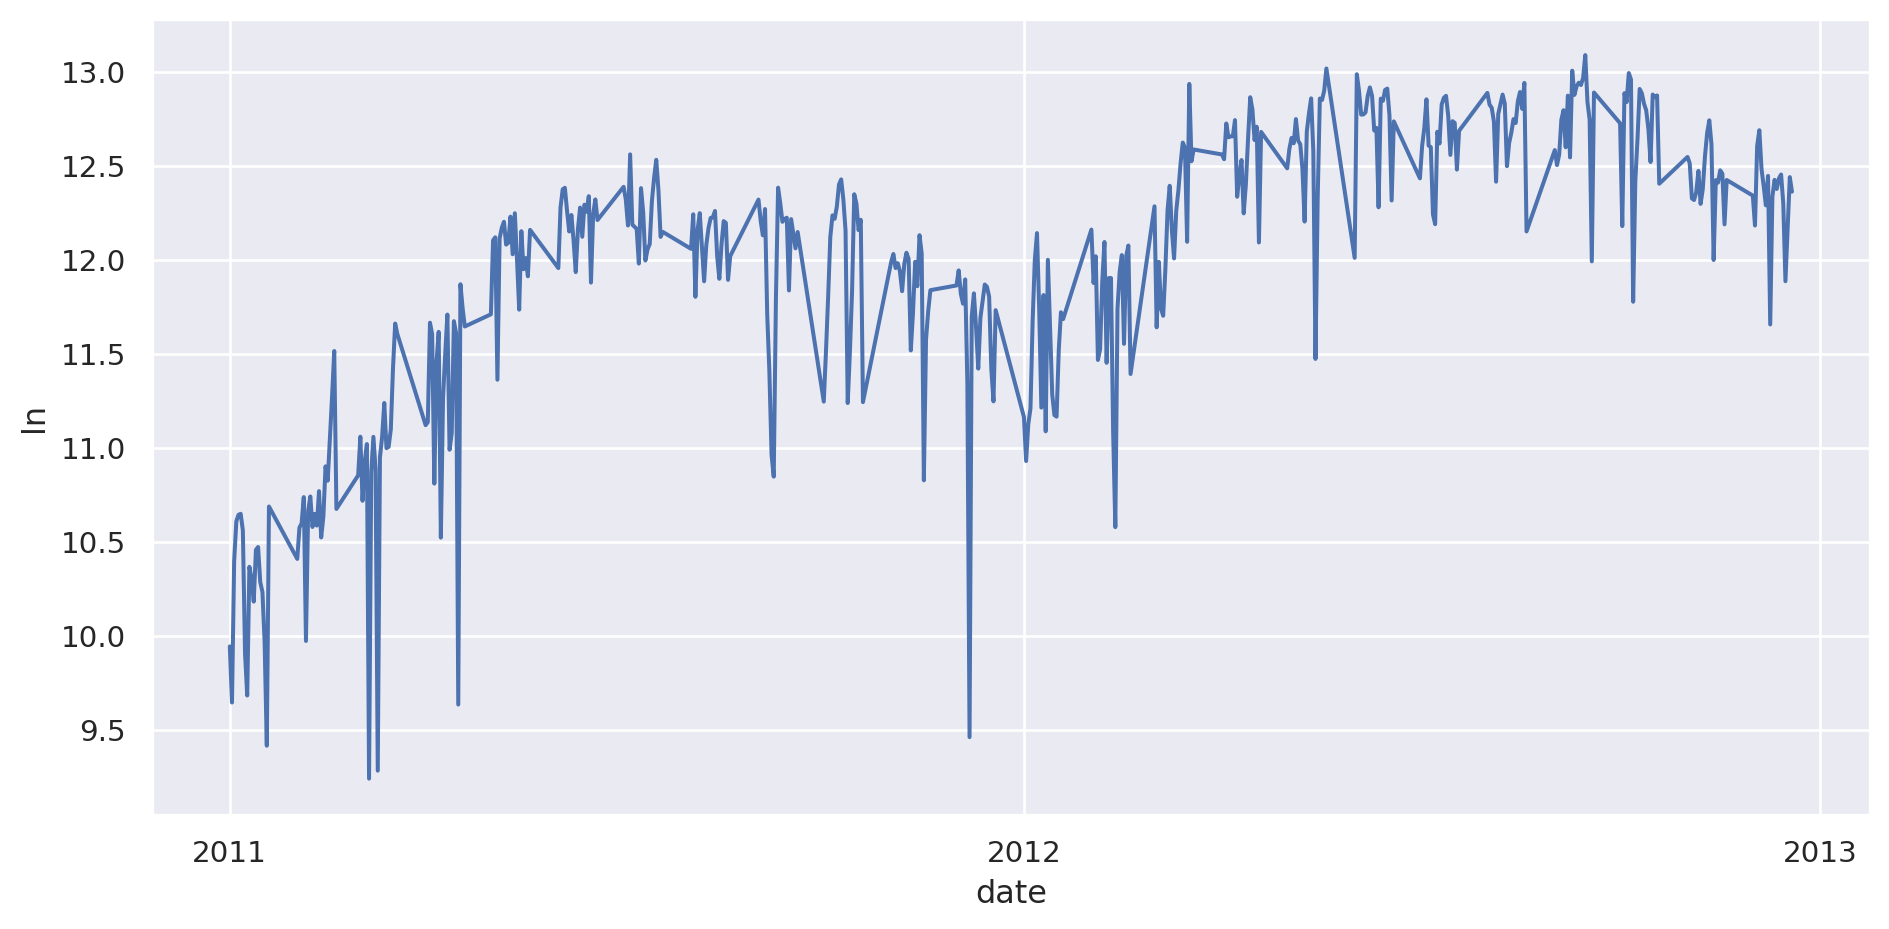

In [318]:
(
    so.Plot(daily, x='date', y='ln')
    .add(so.Line())
    .layout(size=(10, 5))
)

날이갈수록 이용자수가 늘고있음

In [319]:
# add a column for the day of the week
daily['date'] = pd.to_datetime(daily['date'])
daily["wday"] = (
    daily["date"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

In [320]:
daily

date     n wday    resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat -3734.97    1   -2465.24   -2535.98       1  spring   
1   2011-01-02   801  Sun -3525.45    2   -2463.26   -2525.92       1  spring   
2   2011-01-03  1349  Mon -3194.02    3   -2461.25   -2515.87       1  spring   
..         ...   ...  ...      ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon    41.98  352    -404.22    -420.37       4  winter   
454 2012-12-18  5557  Tue  1064.92  353    -409.75    -429.99       4  winter   
455 2012-12-19  5267  Wed   771.22  354    -415.25    -439.61       4  winter   

     most_common_weather weatherv    ln  
0                      1    clear  9.94  
1                      2     mist  9.65  
2                      1    clear 10.40  
..                   ...      ...   ...  
453                    2     mist 12.16  
454                    1    clear 12.44  
455                    1    clear 12.36  

[456 rows x 12 columns]

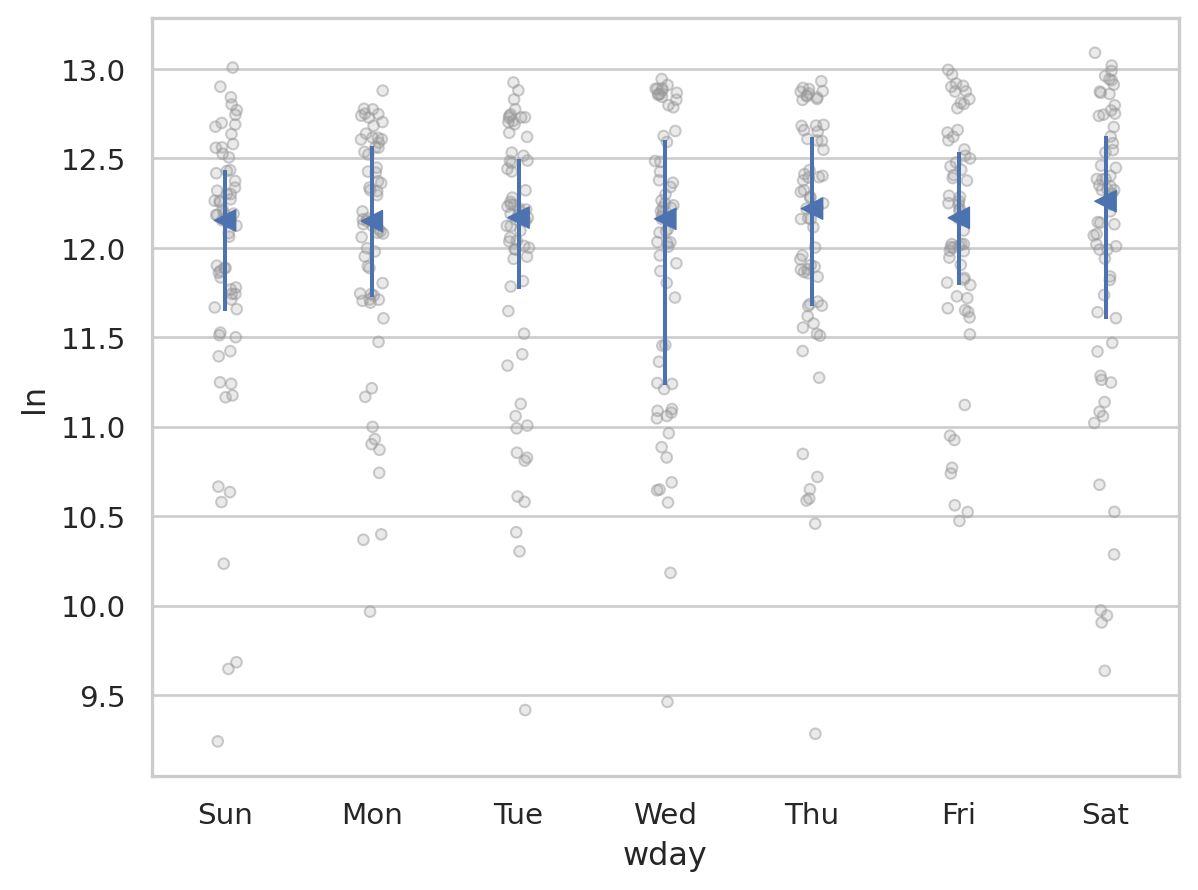

In [321]:
boxplot(daily, "wday", "ln", alpha=.5)

In [322]:
from statsmodels.formula.api import ols 
# 또는 import statsmodels.formula.api as smf

mod1 = ols("ln ~ wday", data=daily).fit()

In [323]:
wday = pd.Categorical(
    ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    categories=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
)
grid = pd.DataFrame({"wday": wday})

In [324]:
grid["pred"] = mod.predict(grid)
grid

daily.groupby("wday")["ln"].mean()

wday
Sun   11.91
Mon   12.02
Tue   11.98
Wed   11.95
Thu   12.05
Fri   12.08
Sat   12.01
Name: ln, dtype: float64

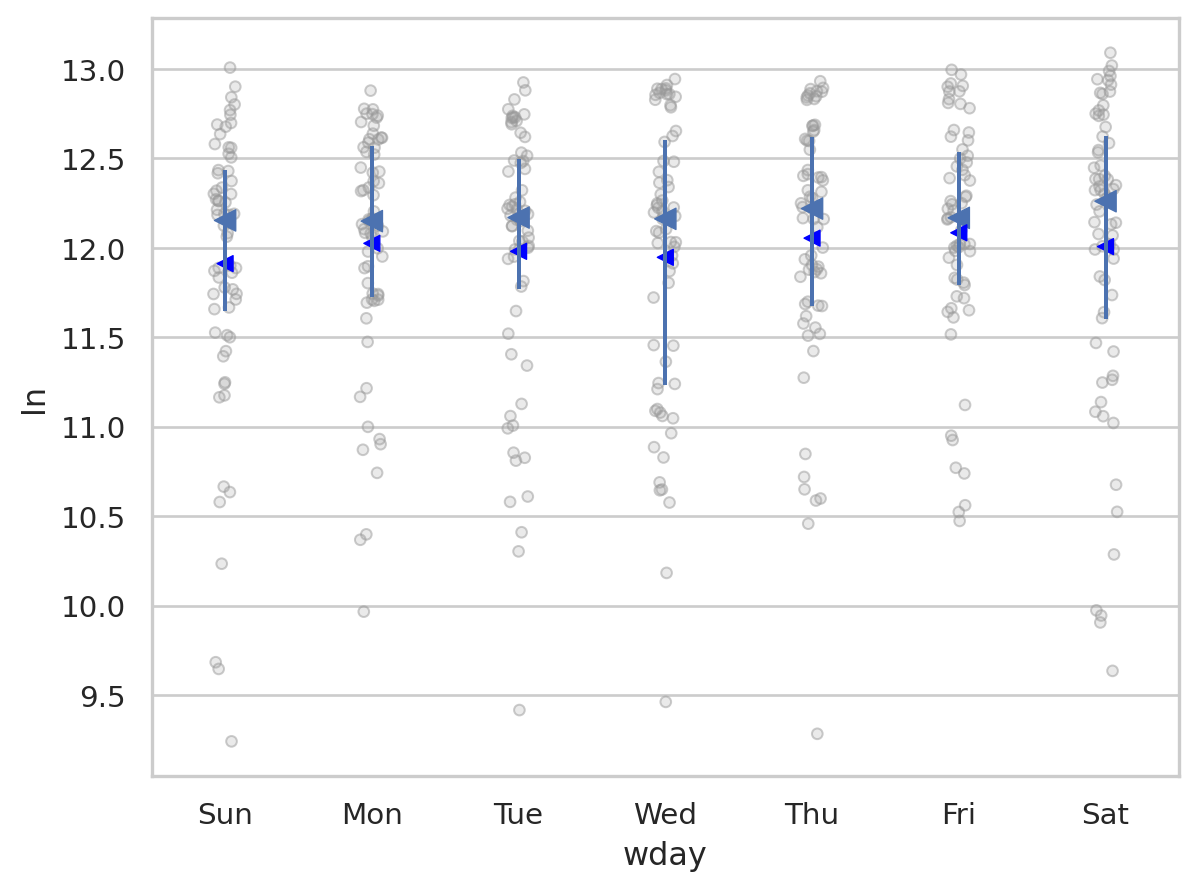

In [325]:
(
    boxplot(daily, "wday", "ln", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.wday, y=grid.pred)
)

In [326]:
# add a column of residuals from mod
daily["resid"] = mod1.resid

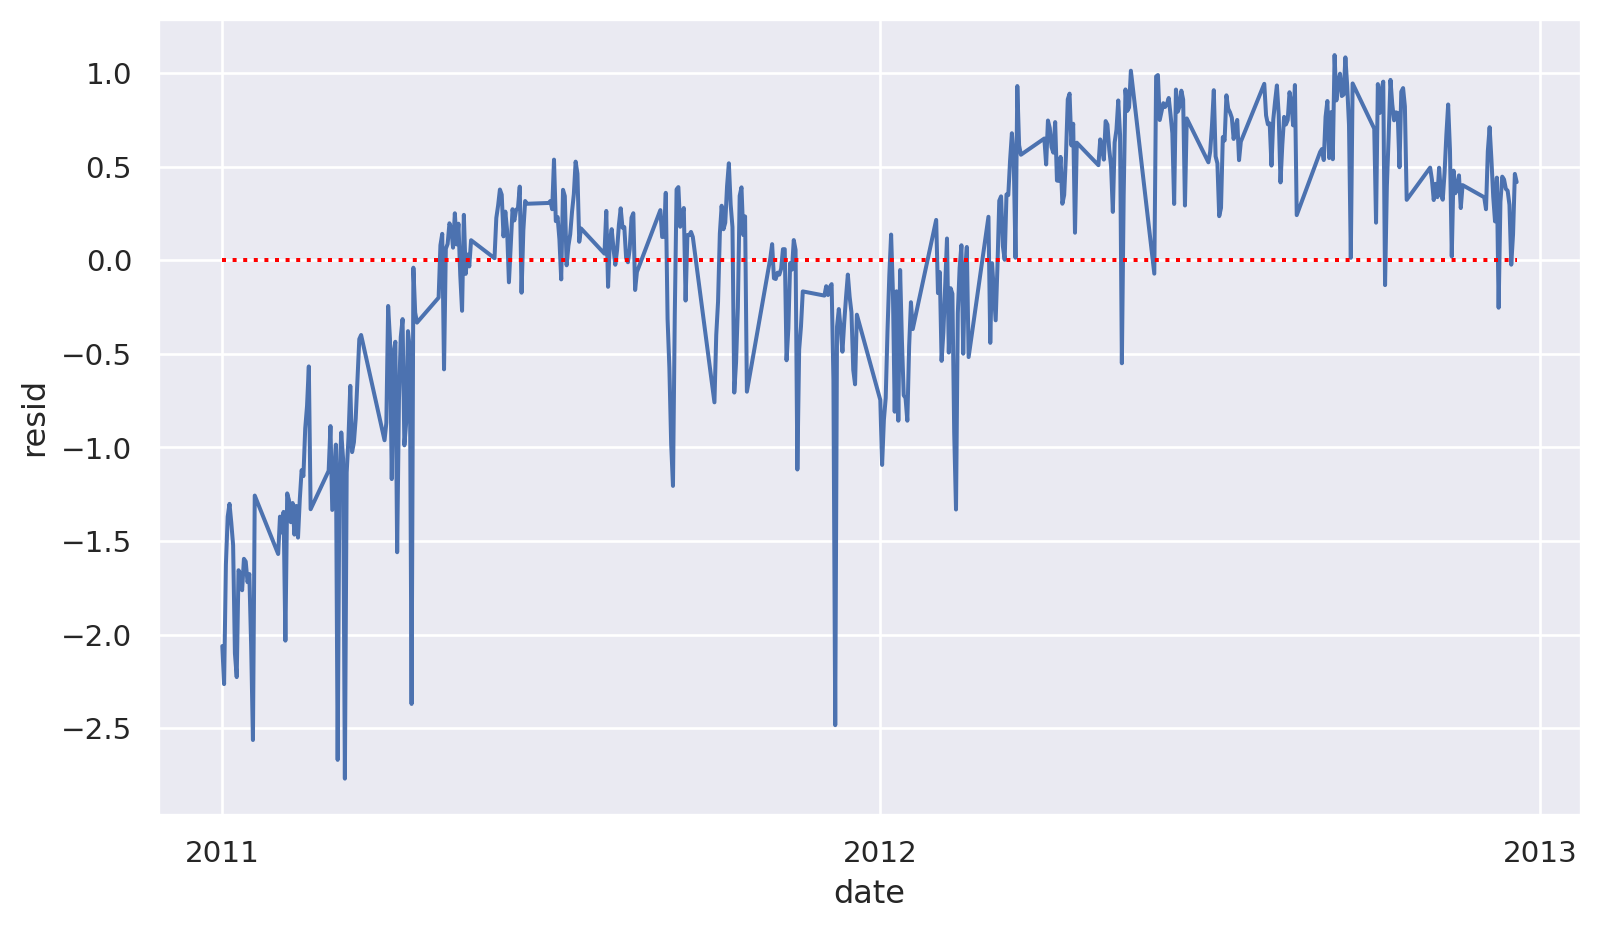

In [327]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

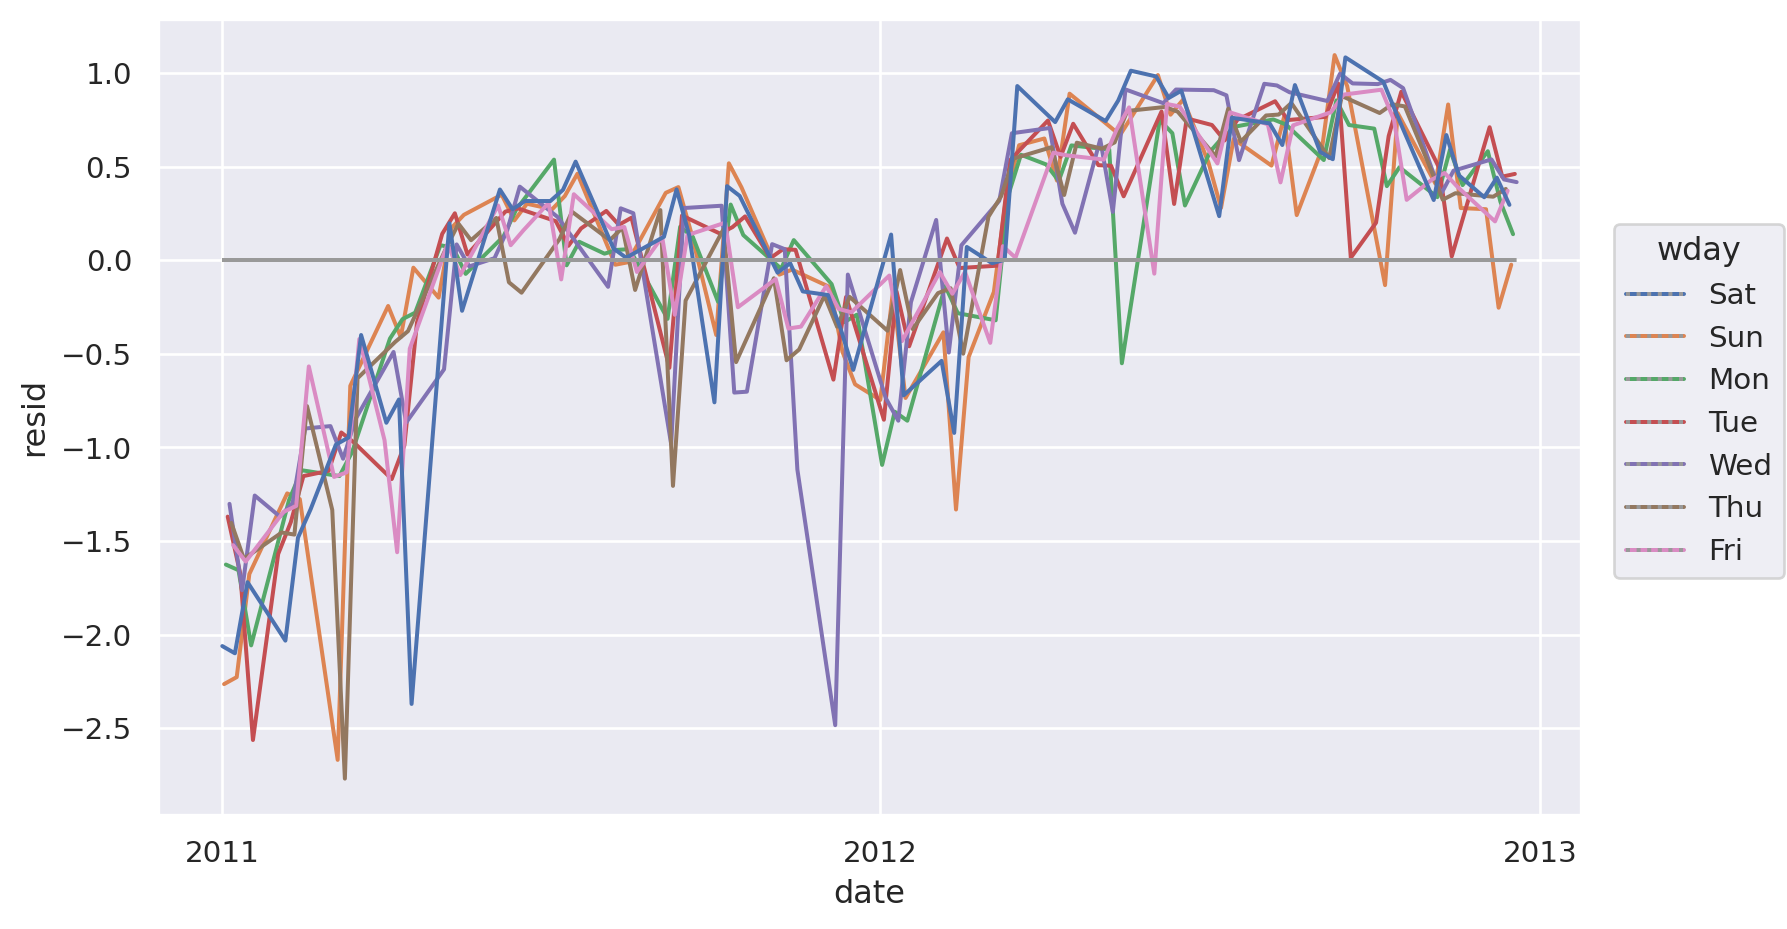

In [328]:
(
    so.Plot(daily, x='date', y='resid', color="wday")
    .add(so.Line())
    .add(so.Line(color=".6", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

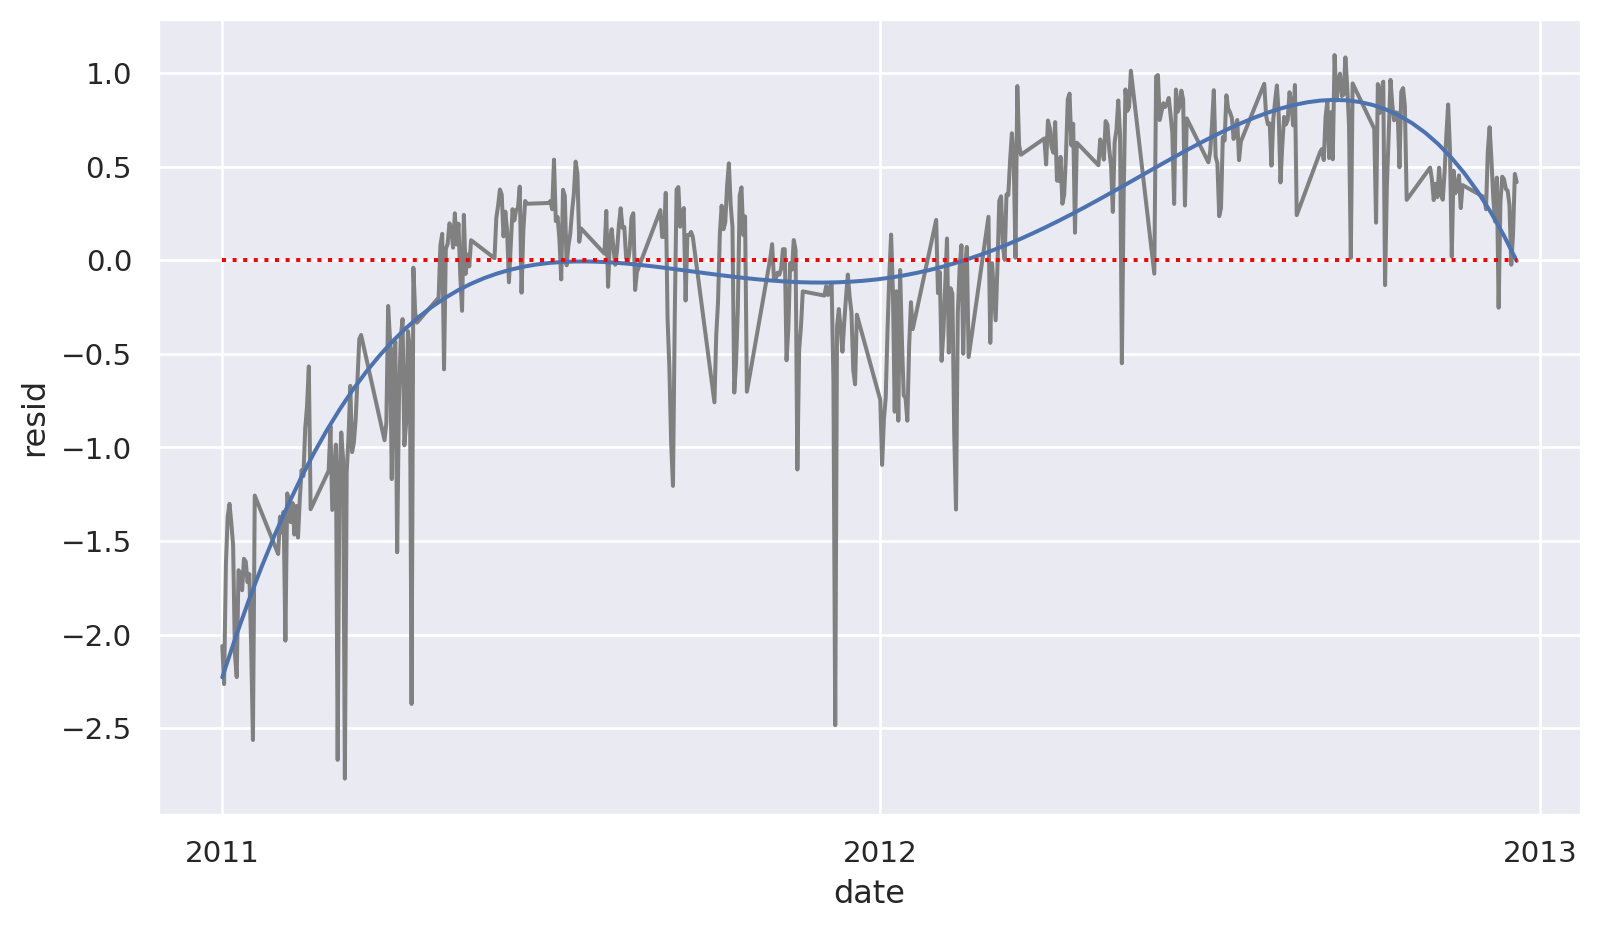

In [329]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line(color=".5"))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

In [330]:
# 일년 중 몇 일째인지 수치형 변수로 추가
daily["day"] = daily["date"].dt.day_of_year

In [331]:
fit_spline = ols("resid ~ cr(day, df=10)", data=daily).fit()
daily["ns_fitted"] = fit_spline.fittedvalues

In [332]:
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["bs_fitted"] = fit_bspline.fittedvalues

In [333]:
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.06    1      -1.19      -1.21       1  spring   
1   2011-01-02   801  Sun  -2.26    2      -1.18      -1.20       1  spring   
2   2011-01-03  1349  Mon  -1.63    3      -1.18      -1.19       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.14  352      -0.06      -0.07       4  winter   
454 2012-12-18  5557  Tue   0.46  353      -0.07      -0.07       4  winter   
455 2012-12-19  5267  Wed   0.42  354      -0.07      -0.08       4  winter   

     most_common_weather weatherv    ln  
0                      1    clear  9.94  
1                      2     mist  9.65  
2                      1    clear 10.40  
..                   ...      ...   ...  
453                    2     mist 12.16  
454                    1    clear 12.44  
455                    1    clear 12.36  

[456 rows x 12 columns]

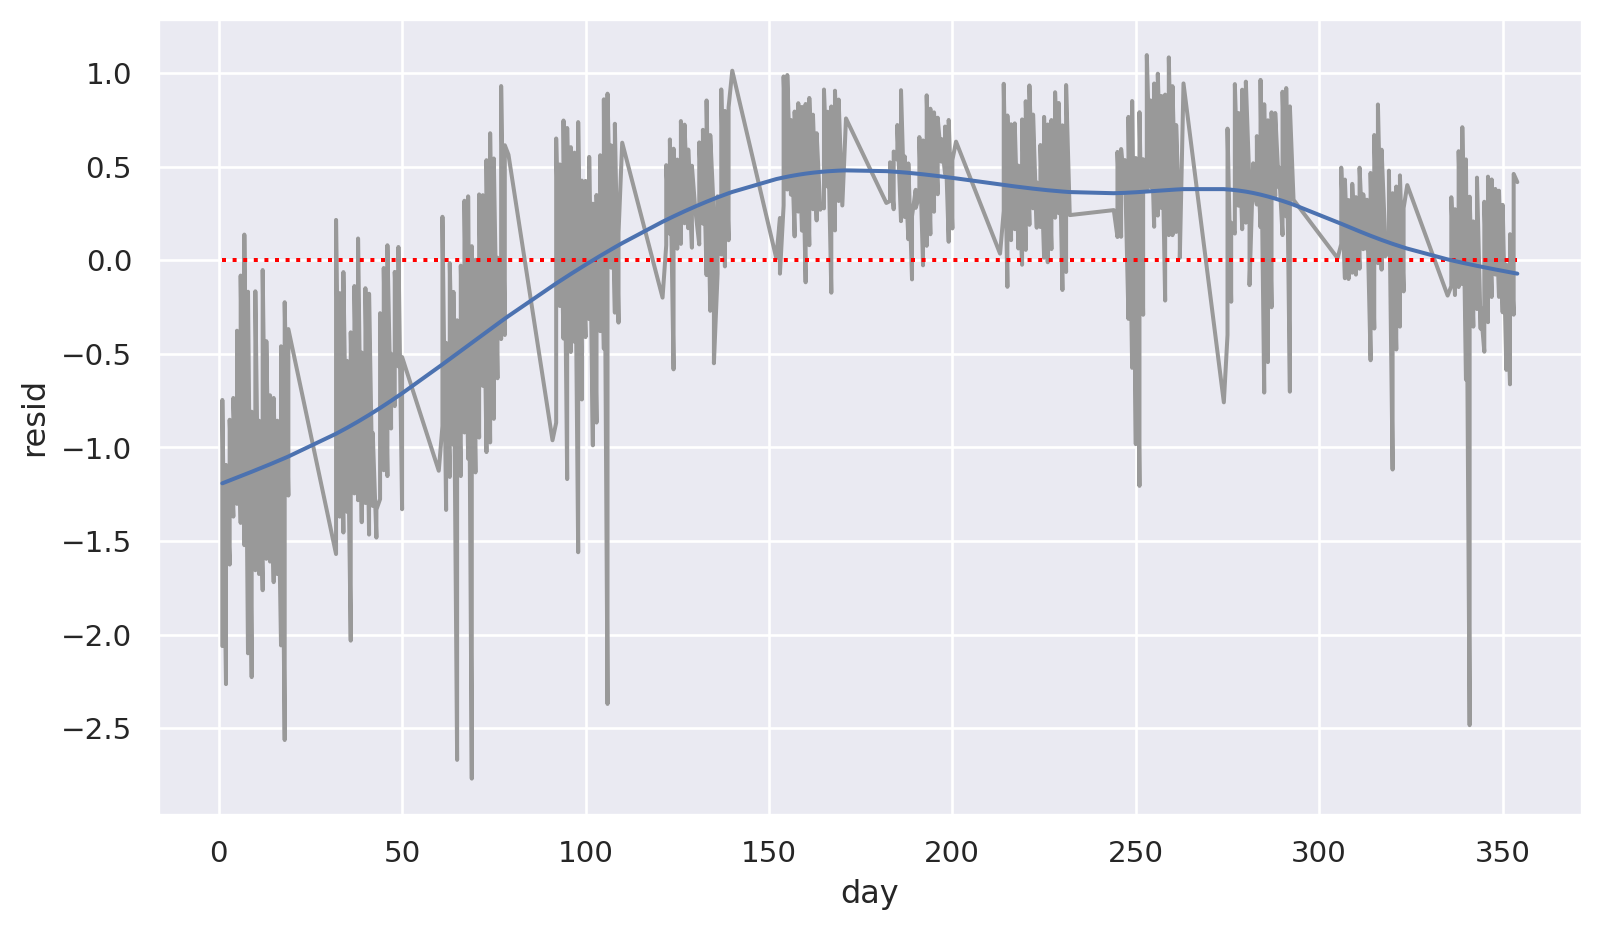

In [334]:
p = (
    so.Plot(daily, x='day', y='resid')
    .add(so.Line(color=".6"))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .add(so.Line(), x=daily.day, y=daily.ns_fitted)  # predicted line by natural spline model
    .layout(size=(8.5, 5))
)
p

여름가을에 사용자수가 많음

B-splines를 이용한 모델에 의한 예측값을 추가로 그리면,

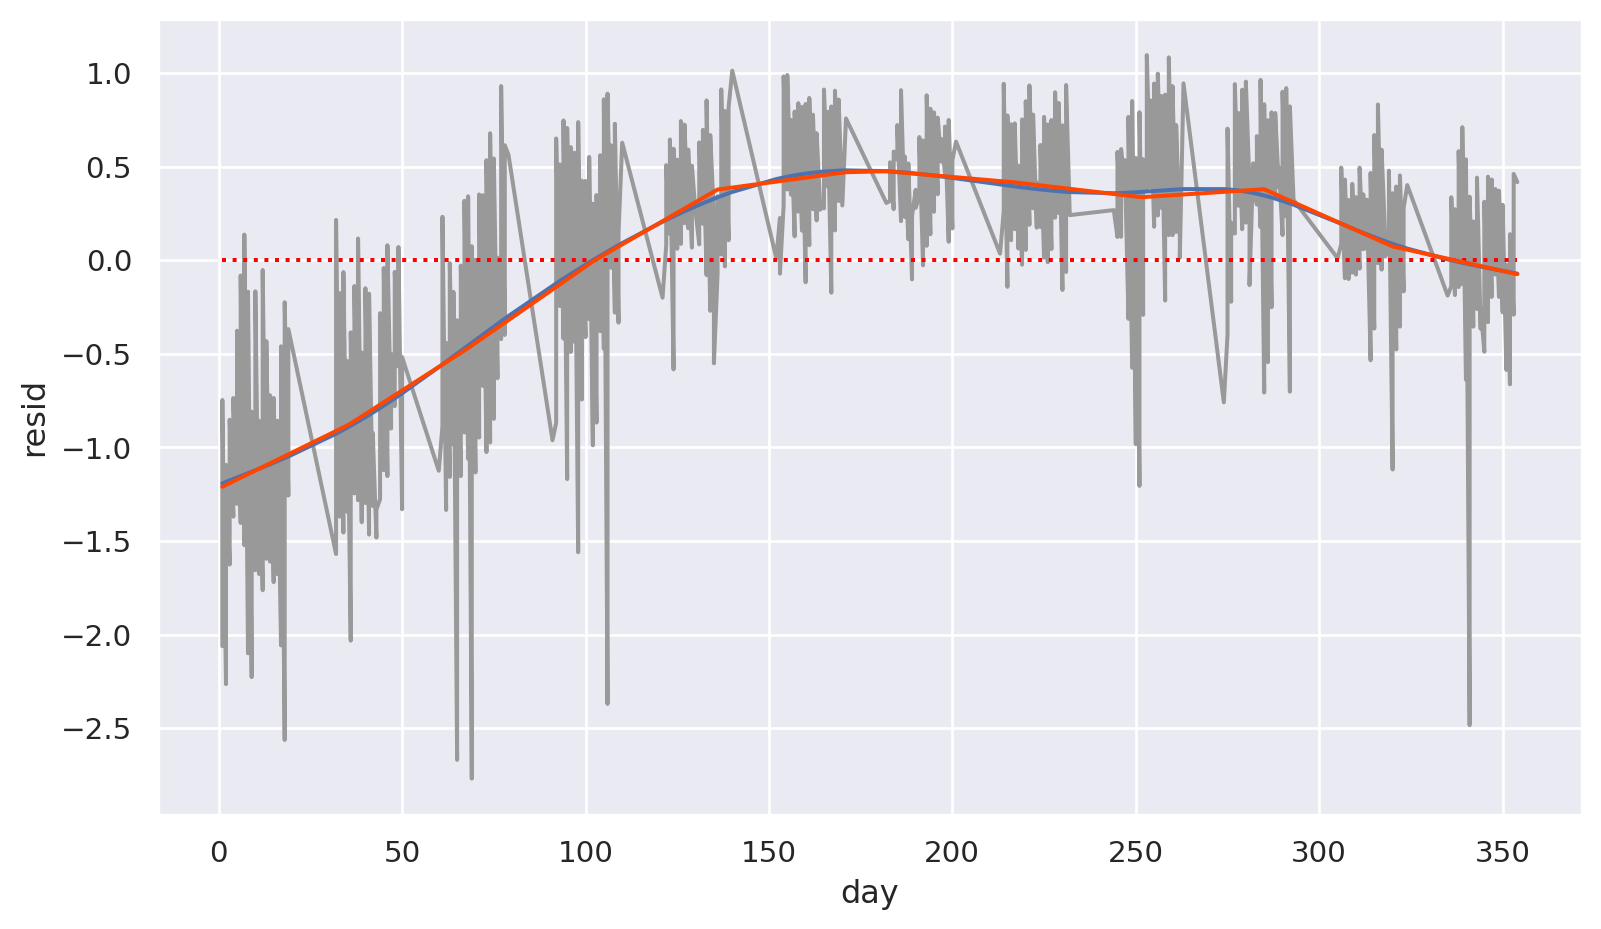

In [335]:
# predicted line by B-spline model
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["bs_fitted"] = fit_bspline.fittedvalues

p.add(so.Line(color="orangered"), x=daily.day, y=daily.bs_fitted)

---

# 시즌별 

In [336]:
season_mapping = {
    1: "spring",
    2: "summer",
    3: "fall",
    4: "winter"
}
bikeshare['seasonv'] = bikeshare['season'].map(season_mapping)
bikeshare

datetime  season  holiday  workingday  weather  temp  atemp  \
0     2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1     2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2     2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
...                   ...     ...      ...         ...      ...   ...    ...   
10883 2012-12-19 21:00:00       4        0           1        1 13.94  15.91   
10884 2012-12-19 22:00:00       4        0           1        1 13.94  17.43   
10885 2012-12-19 23:00:00       4        0           1        1 13.12  16.66   

       humidity  windspeed  casual  registered  count  year        date  day  \
0            81       0.00       3          13     16  2011  2011-01-01    1   
1            80       0.00       8          32     40  2011  2011-01-01    1   
2            80       0.00       5          27     32  2011  2011-01-01    1   
...         ...        ...     ...         ...    ...   ...         ...  ...   
10883        61      15.00       4         164    168  2012  2012-12-19  354   
10884        61       6.00      12         117    129  2012  2012-12-19  354   
10885        66       9.00       4          84     88  2012  2012-12-19  354   

           time seasonv weatherv  most_common_weather  
0      00:00:00  spring    clear                    1  
1      01:00:00  spring    clear                    1  
2      02:00:00  spring    clear                    1  
...         ...     ...      ...                  ...  
10883  21:00:00  winter    clear                    1  
10884  22:00:00  winter    clear                    1  
10885  23:00:00  winter    clear                    1  

[10886 rows x 19 columns]

In [337]:
season = bikeshare.groupby('date')['season'].agg(lambda x: x.value_counts().index[0])
daily['season'] = daily['date'].map(season)
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.06    1      -1.19      -1.21       1  spring   
1   2011-01-02   801  Sun  -2.26    2      -1.18      -1.20       1  spring   
2   2011-01-03  1349  Mon  -1.63    3      -1.18      -1.19       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.14  352      -0.06      -0.07       4  winter   
454 2012-12-18  5557  Tue   0.46  353      -0.07      -0.07       4  winter   
455 2012-12-19  5267  Wed   0.42  354      -0.07      -0.08       4  winter   

     most_common_weather weatherv    ln  
0                      1    clear  9.94  
1                      2     mist  9.65  
2                      1    clear 10.40  
..                   ...      ...   ...  
453                    2     mist 12.16  
454                    1    clear 12.44  
455                    1    clear 12.36  

[456 rows x 12 columns]

In [338]:
season_mapping = {
    1: "spring",
    2: "summer",
    3: "fall",
    4: "winter"
}
daily['seasonv'] = daily['season'].map(season_mapping)
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.06    1      -1.19      -1.21       1  spring   
1   2011-01-02   801  Sun  -2.26    2      -1.18      -1.20       1  spring   
2   2011-01-03  1349  Mon  -1.63    3      -1.18      -1.19       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.14  352      -0.06      -0.07       4  winter   
454 2012-12-18  5557  Tue   0.46  353      -0.07      -0.07       4  winter   
455 2012-12-19  5267  Wed   0.42  354      -0.07      -0.08       4  winter   

     most_common_weather weatherv    ln  
0                      1    clear  9.94  
1                      2     mist  9.65  
2                      1    clear 10.40  
..                   ...      ...   ...  
453                    2     mist 12.16  
454                    1    clear 12.44  
455                    1    clear 12.36  

[456 rows x 12 columns]

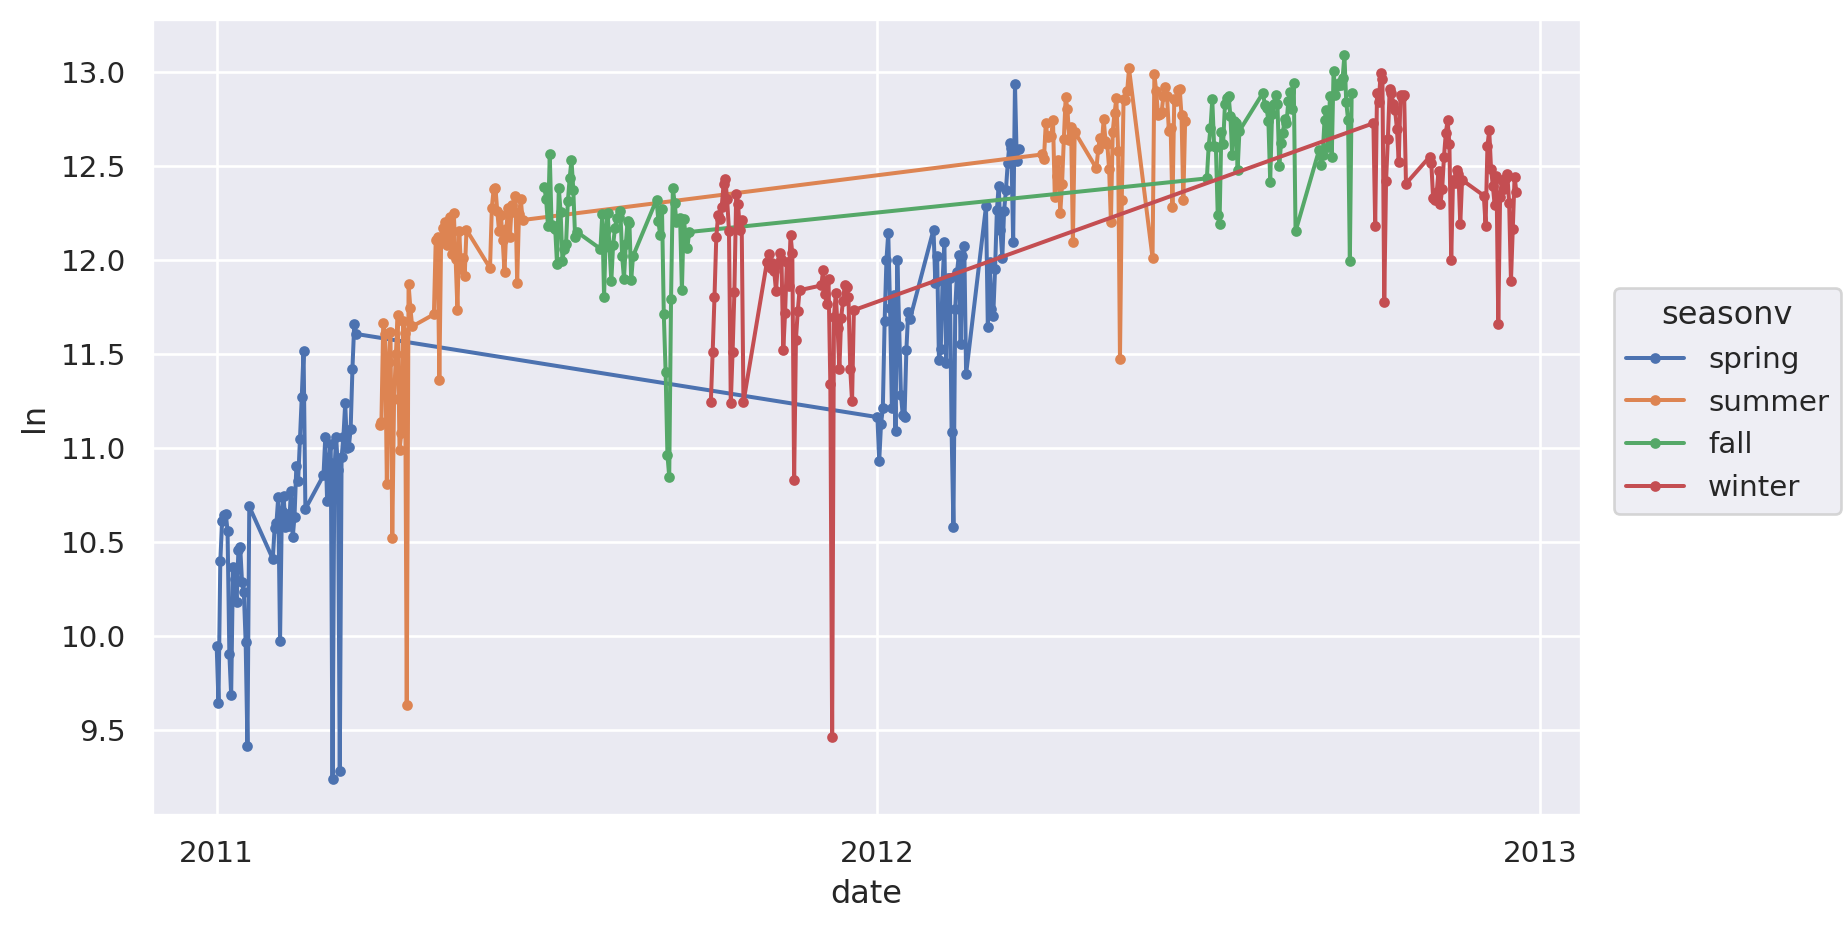

In [340]:
(
    so.Plot(daily, x='date', y='ln', color="seasonv")
    .add(so.Line(marker="."))
    .layout(size=(8.5, 5))
)

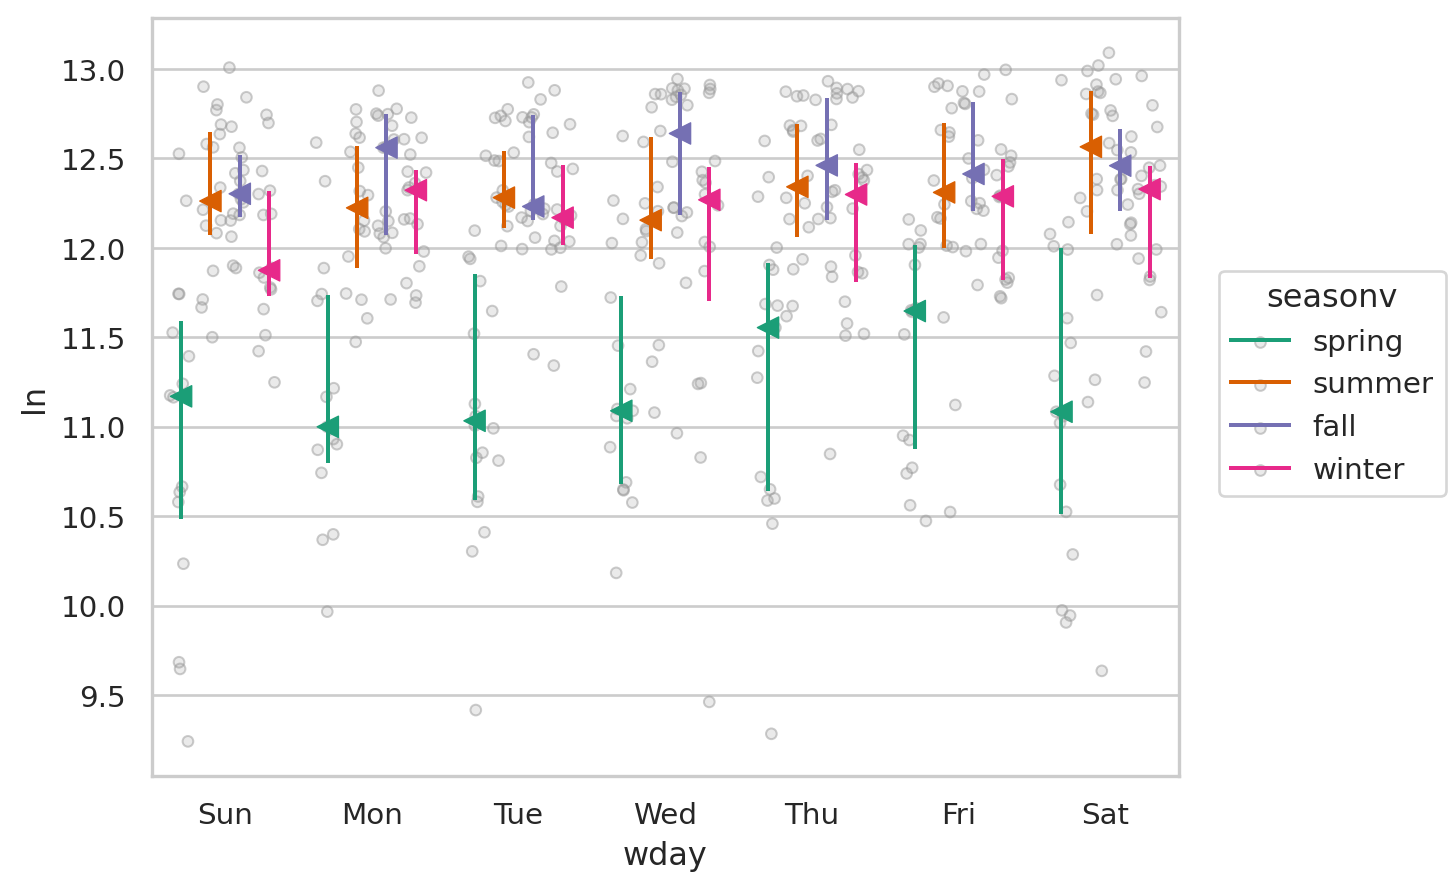

In [341]:
boxplot(daily, x="wday", y="ln", color="seasonv", alpha=.5)

---

In [375]:
from statsmodels.formula.api import ols 
# 또는 import statsmodels.formula.api as smf

mod2 = ols("ln ~ seasonv", data=daily).fit()

In [376]:
sasonv = pd.Categorical(
    ["spring", "summer", "fall", "winter"],
    categories=["spring", "summer", "fall", "winter"],
)
grid = pd.DataFrame({"seasonv": seasonv})

In [377]:
grid["pred"] = mod2.predict(grid)
grid

daily.groupby("seasonv")["ln"].mean()

seasonv
fall     12.40
spring   11.22
summer   12.24
winter   12.14
Name: ln, dtype: float64

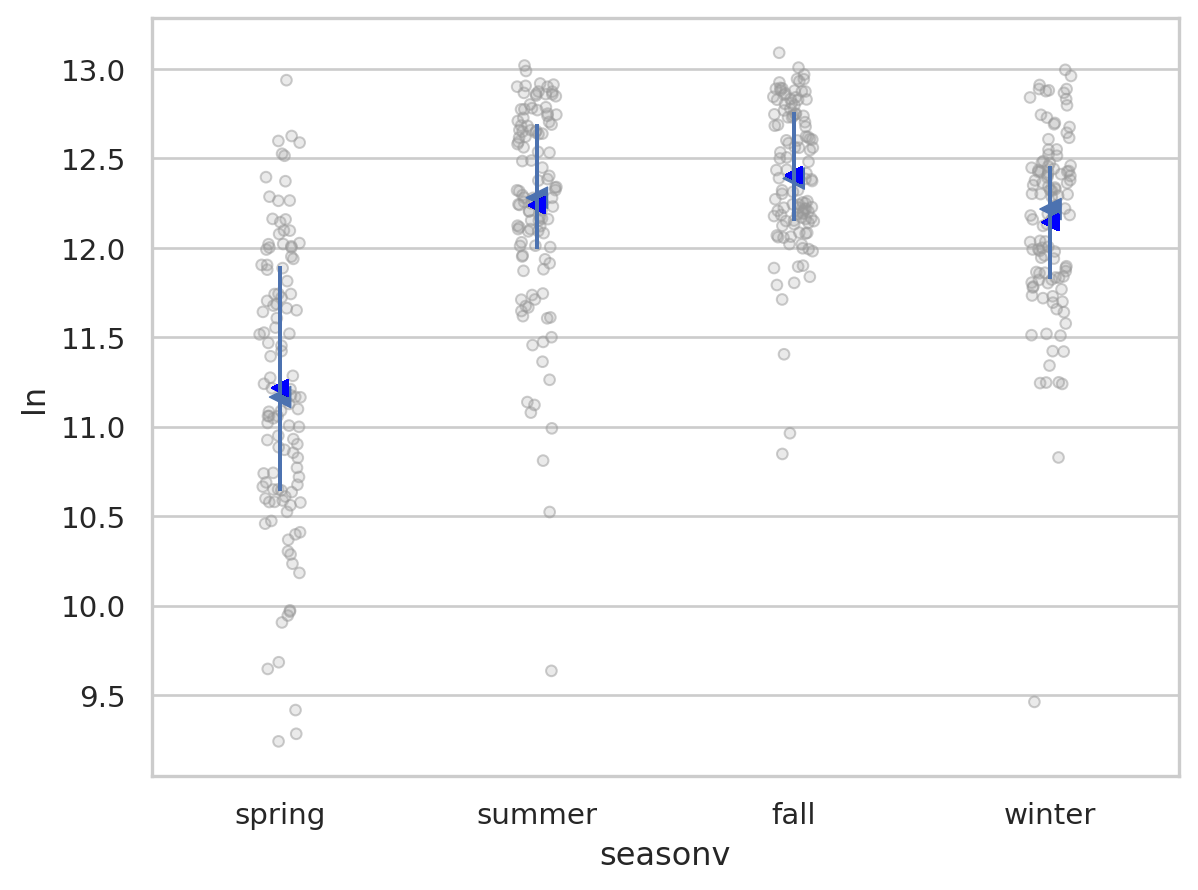

In [378]:
(
    boxplot(daily, "seasonv", "ln", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.seasonv, y=grid.pred)
)

residuals

In [379]:
# add a column of residuals from mod
daily["resid"] = mod2.resid

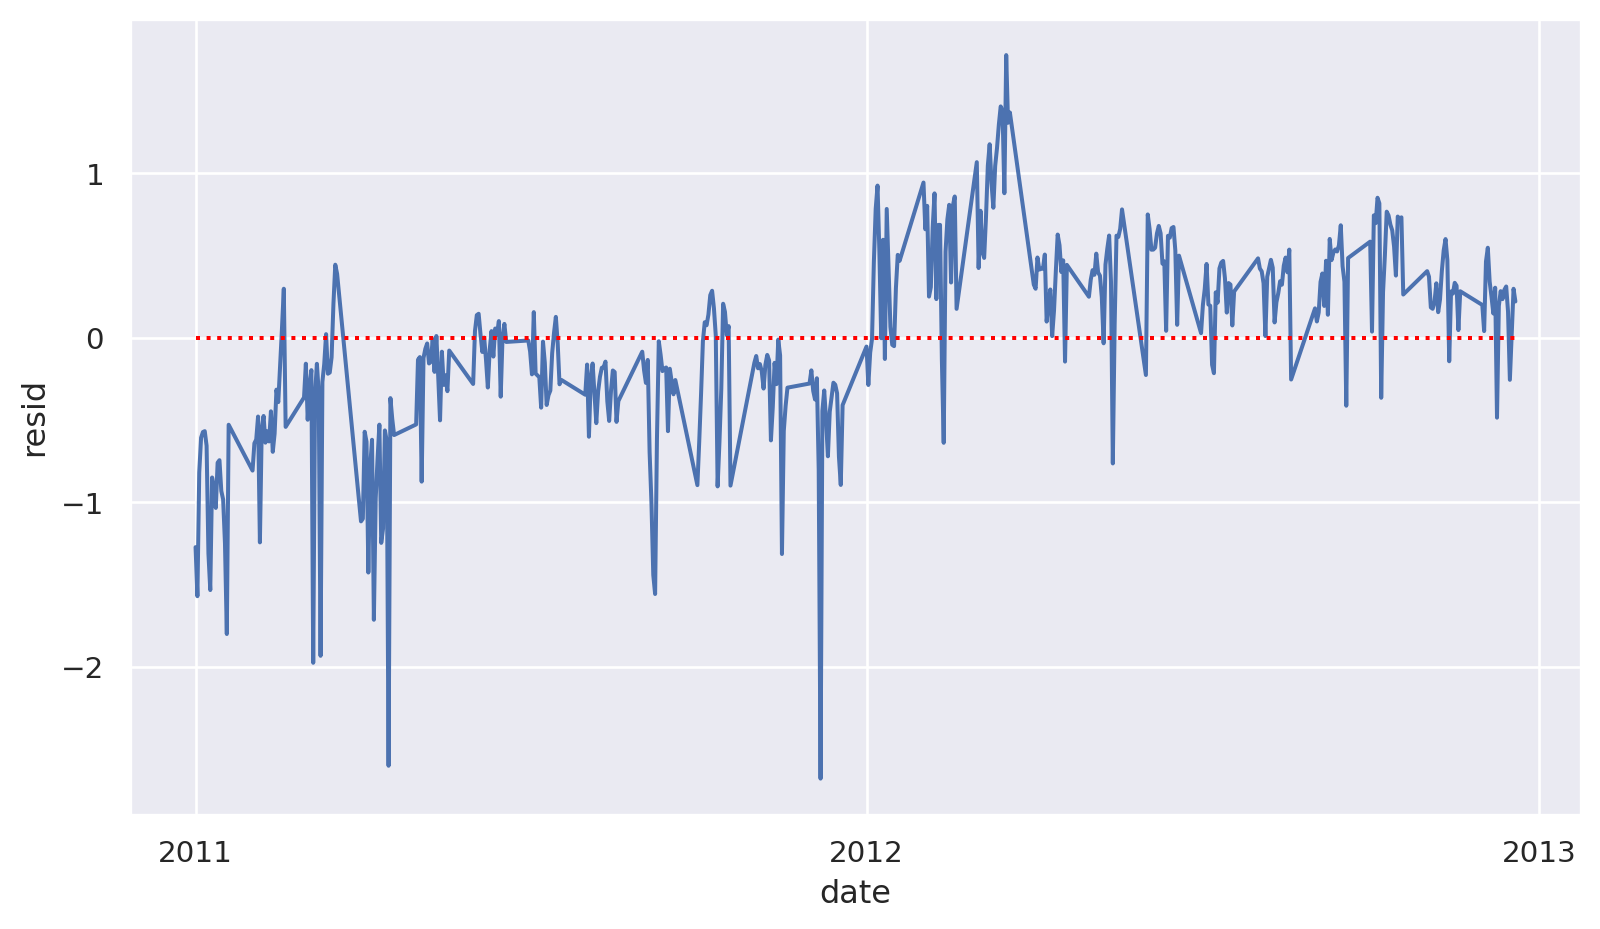

In [380]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

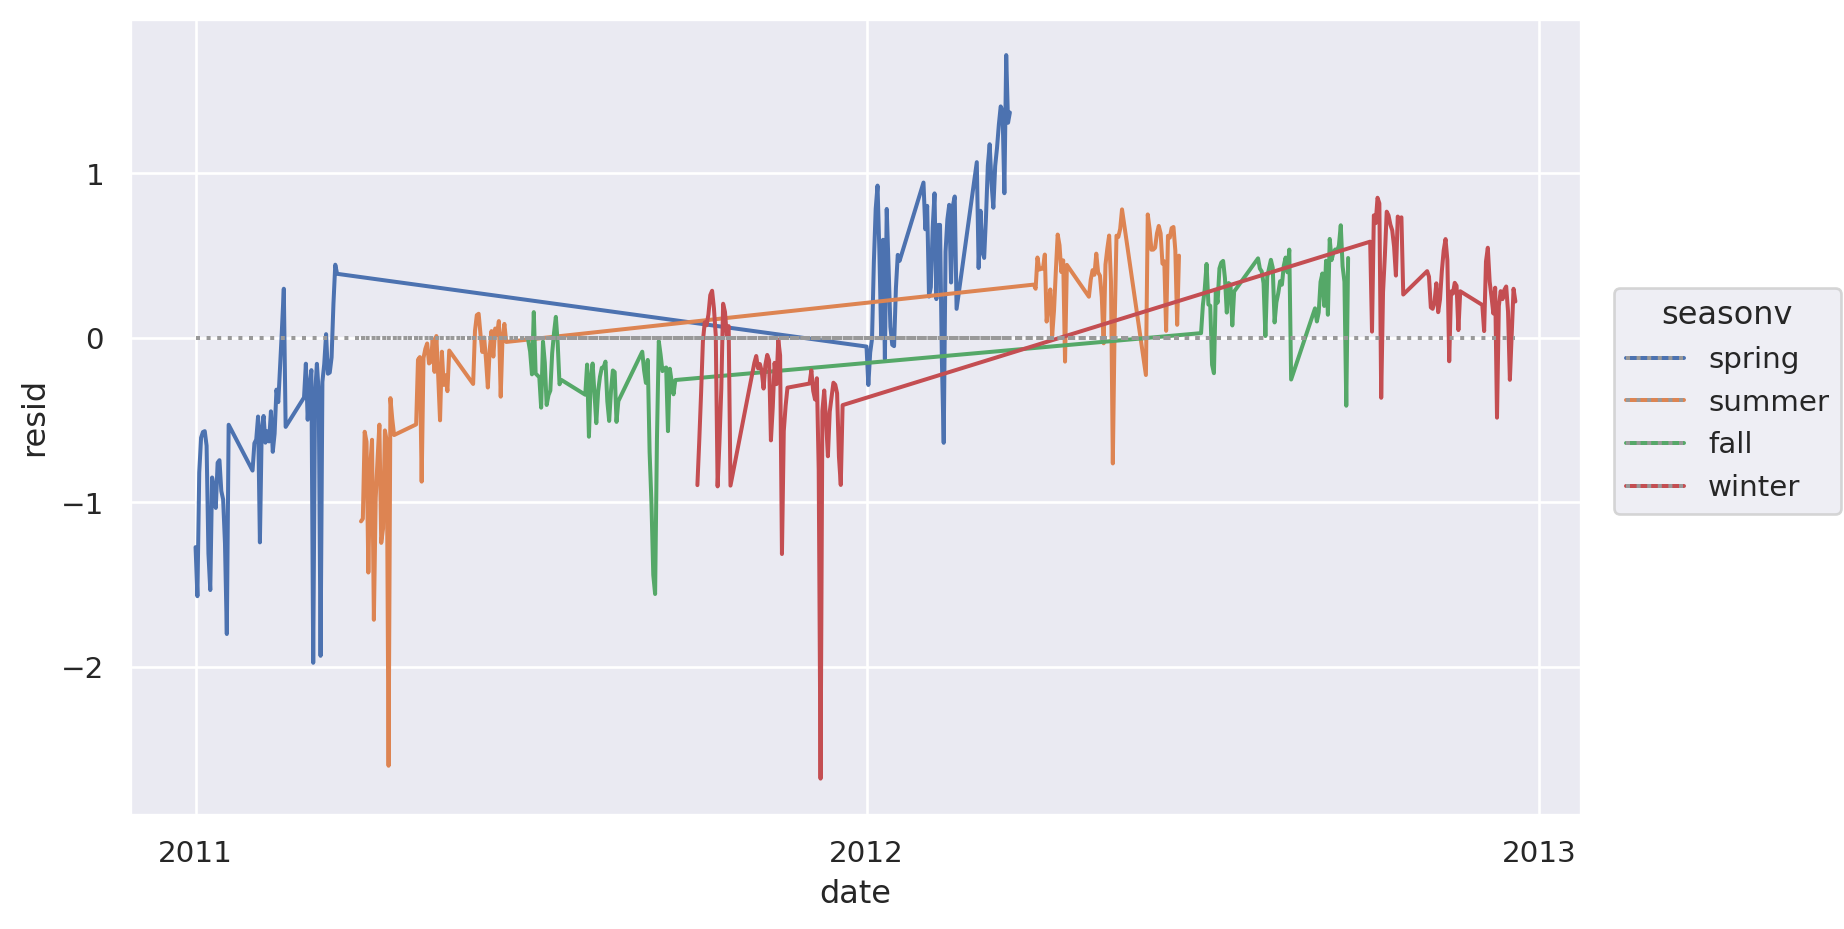

In [381]:
(
    so.Plot(daily, x='date', y='resid', color="seasonv")
    .add(so.Line())
    .add(so.Line(color=".6", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

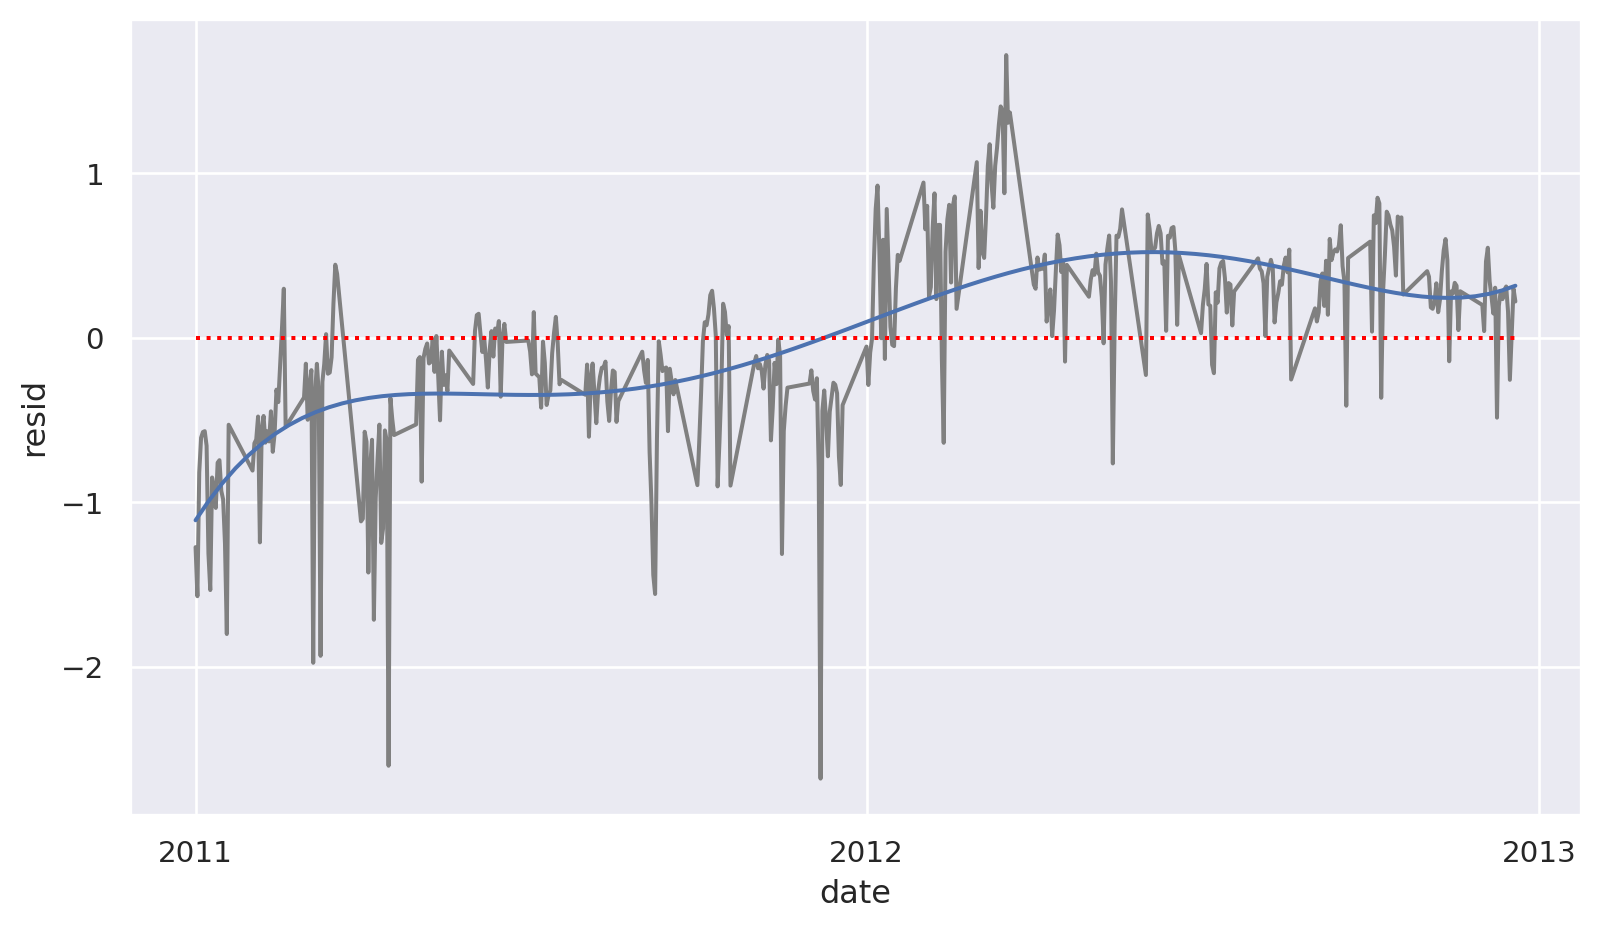

In [382]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line(color=".5"))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

In [383]:
# 일년 중 몇 일째인지 수치형 변수로 추가
daily["day"] = daily["date"].dt.day_of_year

In [384]:
fit_spline = ols("resid ~ cr(day, df=10)", data=daily).fit()
daily["season_ns_fitted"] = fit_spline.fittedvalues

In [385]:
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["season_bs_fitted"] = fit_bspline.fittedvalues
daily.head(7)

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0 2011-01-01   985  Sat  -1.27    1      -1.19    -712.99       1  spring   
1 2011-01-02   801  Sun  -1.57    2      -1.18    -703.76       1  spring   
2 2011-01-03  1349  Mon  -0.82    3      -1.18    -694.52       1  spring   
3 2011-01-04  1562  Tue  -0.61    4      -1.17    -685.28       1  spring   
4 2011-01-05  1600  Wed  -0.57    5      -1.16    -676.05       1  spring   
5 2011-01-06  1606  Thu  -0.57    6      -1.15    -666.81       1  spring   
6 2011-01-07  1510  Fri  -0.66    7      -1.15    -657.57       1  spring   

   most_common_weather weatherv    ln  sason_bs_fitted  season_ns_fitted  \
0                    1    clear  9.94          -712.99             -0.46   
1                    2     mist  9.65          -703.76             -0.45   
2                    1    clear 10.40          -694.52             -0.43   
3                    1    clear 10.61          -685.28             -0.42   
4                    1    clear 10.64          -676.05             -0.41   
5                    1    clear 10.65          -666.81             -0.40   
6                    2     mist 10.56          -657.57             -0.39   

   season_bs_fitted  
0             -0.43  
1             -0.42  
2             -0.41  
3             -0.40  
4             -0.39  
5             -0.38  
6             -0.37

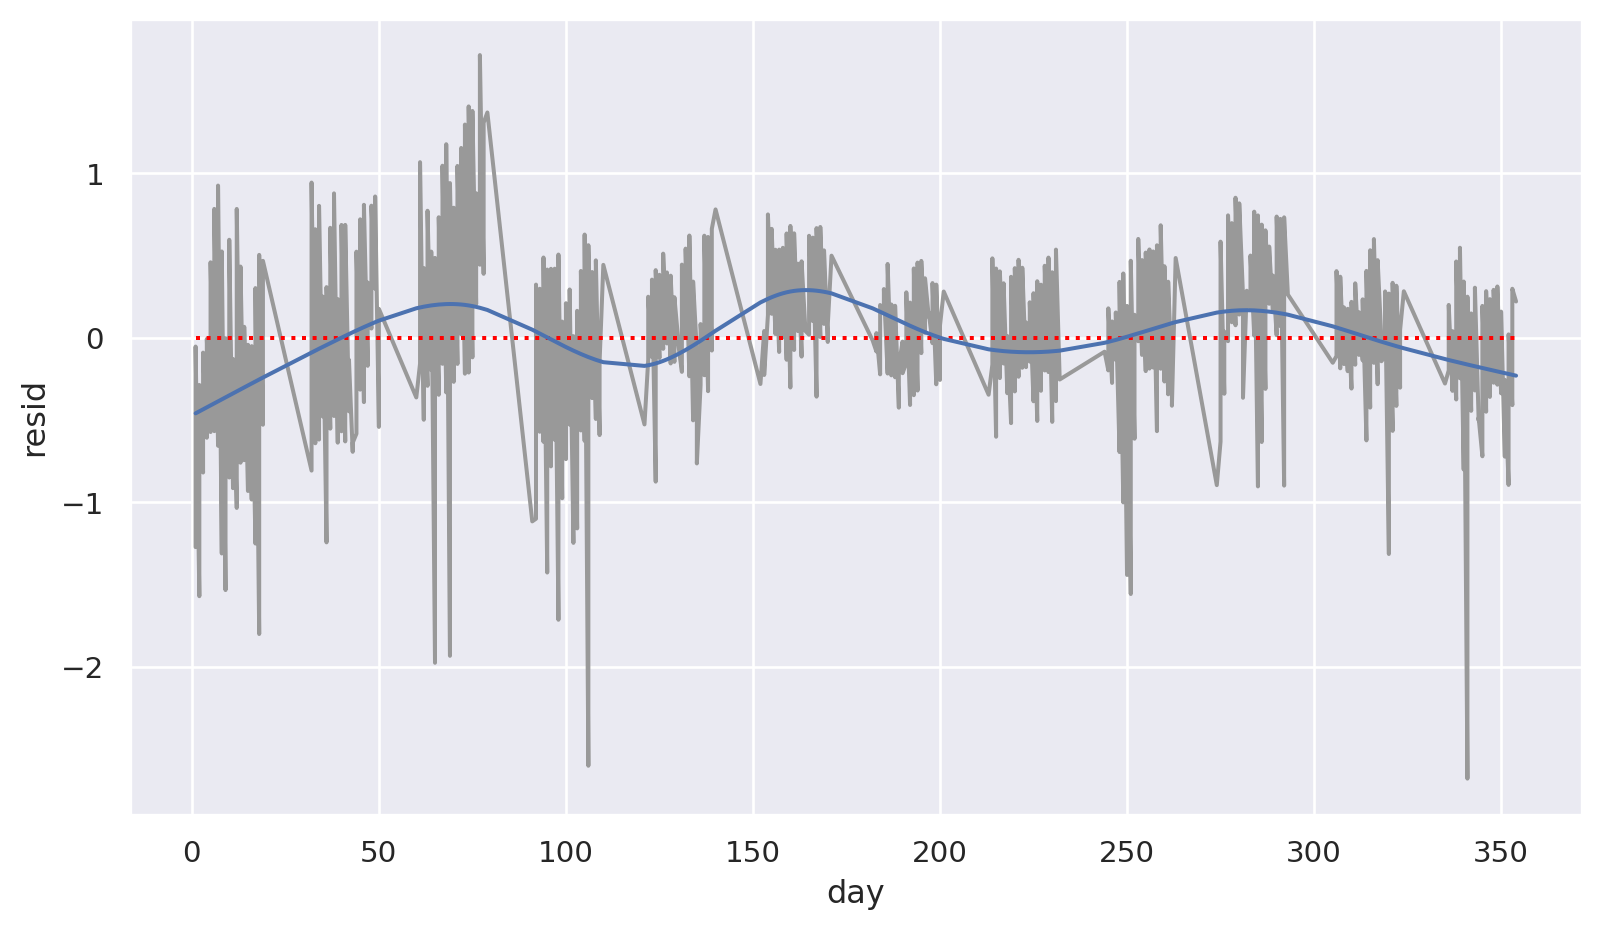

In [386]:
p = (
    so.Plot(daily, x='day', y='resid')
    .add(so.Line(color=".6"))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .add(so.Line(), x=daily.day, y=daily.season_ns_fitted)  # predicted line by natural spline model
    .layout(size=(8.5, 5))
)
p

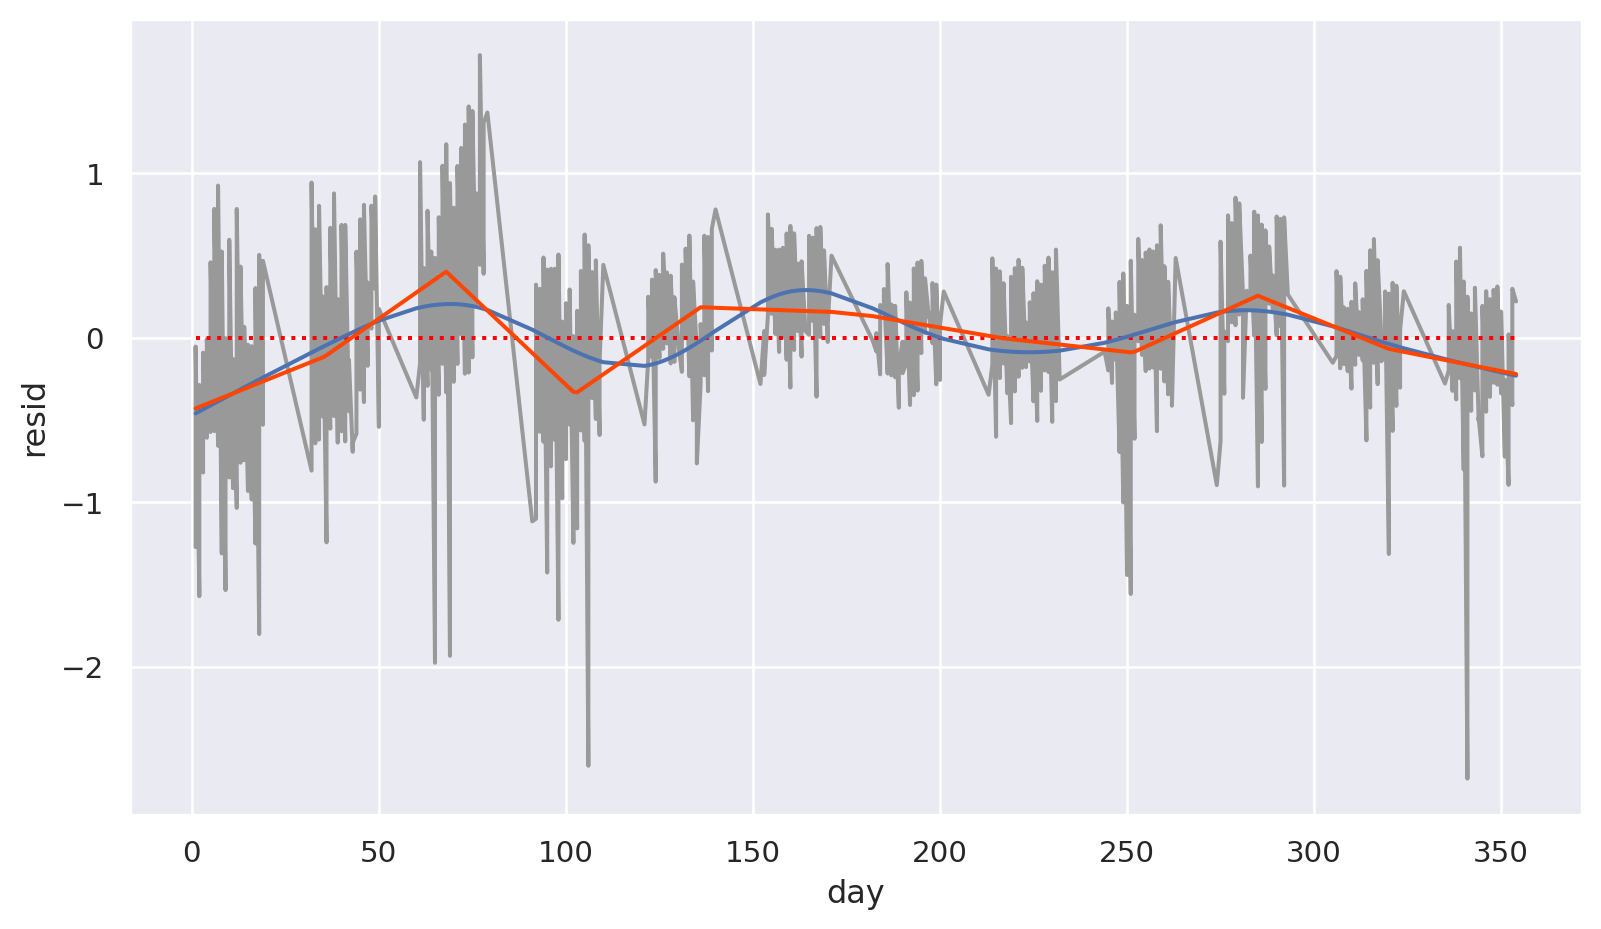

In [387]:
# predicted line by B-spline model
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["sason_bs_fitted"] = fit_bspline.fittedvalues

p.add(so.Line(color="orangered"), x=daily.day, y=daily.season_bs_fitted)

---

# 날씨별

In [497]:
weather_mapping = {
    1: "clear",
    2: "mist",
    3: "light rain",
    4: "heavy rain"
}
bikeshare['weatherv'] = bikeshare['weather'].map(weather_mapping)
bikeshare

datetime  season  holiday  workingday  weather  temp  atemp  \
0     2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1     2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2     2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
...                   ...     ...      ...         ...      ...   ...    ...   
10883 2012-12-19 21:00:00       4        0           1        1 13.94  15.91   
10884 2012-12-19 22:00:00       4        0           1        1 13.94  17.43   
10885 2012-12-19 23:00:00       4        0           1        1 13.12  16.66   

       humidity  windspeed  casual  registered  count  year        date  day  \
0            81       0.00       3          13     16  2011  2011-01-01    1   
1            80       0.00       8          32     40  2011  2011-01-01    1   
2            80       0.00       5          27     32  2011  2011-01-01    1   
...         ...        ...     ...         ...    ...   ...         ...  ...   
10883        61      15.00       4         164    168  2012  2012-12-19  354   
10884        61       6.00      12         117    129  2012  2012-12-19  354   
10885        66       9.00       4          84     88  2012  2012-12-19  354   

           time seasonv weatherv  most_common_weather  
0      00:00:00  spring    clear                    1  
1      01:00:00  spring    clear                    1  
2      02:00:00  spring    clear                    1  
...         ...     ...      ...                  ...  
10883  21:00:00  winter    clear                    1  
10884  22:00:00  winter    clear                    1  
10885  23:00:00  winter    clear                    1  

[10886 rows x 19 columns]

In [498]:
bikeshare['date'] = pd.to_datetime(bikeshare['date']).dt.date
#date'별로 groupby하여 'weather'의 최빈값을 구합니다
most_common_weather = bikeshare.groupby('date')['weather'].agg(lambda x: x.value_counts().index[0])

bikeshare['most_common_weather'] = bikeshare['date'].map(most_common_weather)
bikeshare

datetime  season  holiday  workingday  weather  temp  atemp  \
0     2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1     2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2     2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
...                   ...     ...      ...         ...      ...   ...    ...   
10883 2012-12-19 21:00:00       4        0           1        1 13.94  15.91   
10884 2012-12-19 22:00:00       4        0           1        1 13.94  17.43   
10885 2012-12-19 23:00:00       4        0           1        1 13.12  16.66   

       humidity  windspeed  casual  registered  count  year        date  day  \
0            81       0.00       3          13     16  2011  2011-01-01    1   
1            80       0.00       8          32     40  2011  2011-01-01    1   
2            80       0.00       5          27     32  2011  2011-01-01    1   
...         ...        ...     ...         ...    ...   ...         ...  ...   
10883        61      15.00       4         164    168  2012  2012-12-19  354   
10884        61       6.00      12         117    129  2012  2012-12-19  354   
10885        66       9.00       4          84     88  2012  2012-12-19  354   

           time seasonv weatherv  most_common_weather  
0      00:00:00  spring    clear                    1  
1      01:00:00  spring    clear                    1  
2      02:00:00  spring    clear                    1  
...         ...     ...      ...                  ...  
10883  21:00:00  winter    clear                    1  
10884  22:00:00  winter    clear                    1  
10885  23:00:00  winter    clear                    1  

[10886 rows x 19 columns]

In [499]:
most_common_weather = bikeshare.groupby('date')['most_common_weather'].agg(lambda x: x.value_counts().index[0])
daily['most_common_weather'] = daily['date'].map(most_common_weather)
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.15    1      -1.19      -1.25       1  spring   
1   2011-01-02   801  Sun  -2.16    2      -1.18      -1.24       1  spring   
2   2011-01-03  1349  Mon  -1.70    3      -1.18      -1.23       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.36  352      -0.06      -0.02       4  winter   
454 2012-12-18  5557  Tue   0.34  353      -0.07      -0.02       4  winter   
455 2012-12-19  5267  Wed   0.26  354      -0.07      -0.03       4  winter   

     most_common_weather  ...    ln  sason_bs_fitted  season_ns_fitted  \
0                      1  ...  9.94            -0.43             -0.46   
1                      2  ...  9.65            -0.42             -0.45   
2                      1  ... 10.40            -0.41             -0.43   
..                   ...  ...   ...              ...               ...   
453                    2  ... 12.16            -0.21             -0.22   
454                    1  ... 12.44            -0.22             -0.22   
455                    1  ... 12.36            -0.22             -0.23   

     season_bs_fitted  weather_ns_fitted  weather_bs_fitted  without_season  \
0               -0.43              -1.23              -1.25           -2.15   
1               -0.42              -1.22              -1.24           -2.16   
2               -0.41              -1.21              -1.23           -1.70   
..                ...                ...                ...             ...   
453             -0.21              -0.01              -0.02            0.36   
454             -0.22              -0.02              -0.02            0.34   
455             -0.22              -0.02              -0.03            0.26   

     with_season  without_weather  with_weather  
0          -1.36            -2.06         -2.15  
1          -1.39            -2.26         -1.99  
2          -0.91            -1.63         -1.64  
..           ...              ...           ...  
453         0.03             0.14          0.17  
454         0.20             0.46          0.33  
455         0.12             0.42          0.24  

[456 rows x 21 columns]

In [500]:
weather_mapping = {
    1: "clear",
    2: "mist",
    3: "light rain",
    4: "heavy rain"
}
daily['weatherv'] = daily['most_common_weather'].map(weather_mapping)
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.15    1      -1.19      -1.25       1  spring   
1   2011-01-02   801  Sun  -2.16    2      -1.18      -1.24       1  spring   
2   2011-01-03  1349  Mon  -1.70    3      -1.18      -1.23       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.36  352      -0.06      -0.02       4  winter   
454 2012-12-18  5557  Tue   0.34  353      -0.07      -0.02       4  winter   
455 2012-12-19  5267  Wed   0.26  354      -0.07      -0.03       4  winter   

     most_common_weather  ...    ln  sason_bs_fitted  season_ns_fitted  \
0                      1  ...  9.94            -0.43             -0.46   
1                      2  ...  9.65            -0.42             -0.45   
2                      1  ... 10.40            -0.41             -0.43   
..                   ...  ...   ...              ...               ...   
453                    2  ... 12.16            -0.21             -0.22   
454                    1  ... 12.44            -0.22             -0.22   
455                    1  ... 12.36            -0.22             -0.23   

     season_bs_fitted  weather_ns_fitted  weather_bs_fitted  without_season  \
0               -0.43              -1.23              -1.25           -2.15   
1               -0.42              -1.22              -1.24           -2.16   
2               -0.41              -1.21              -1.23           -1.70   
..                ...                ...                ...             ...   
453             -0.21              -0.01              -0.02            0.36   
454             -0.22              -0.02              -0.02            0.34   
455             -0.22              -0.02              -0.03            0.26   

     with_season  without_weather  with_weather  
0          -1.36            -2.06         -2.15  
1          -1.39            -2.26         -1.99  
2          -0.91            -1.63         -1.64  
..           ...              ...           ...  
453         0.03             0.14          0.17  
454         0.20             0.46          0.33  
455         0.12             0.42          0.24  

[456 rows x 21 columns]

In [501]:
daily.groupby('weatherv')['n'].sum().reset_index(name="sum")

weatherv      sum
0       clear  1657394
1  light rain    44249
2        mist   383833

날씨가 4,즉 heavy rain일때는 count값이 존재하지 않음

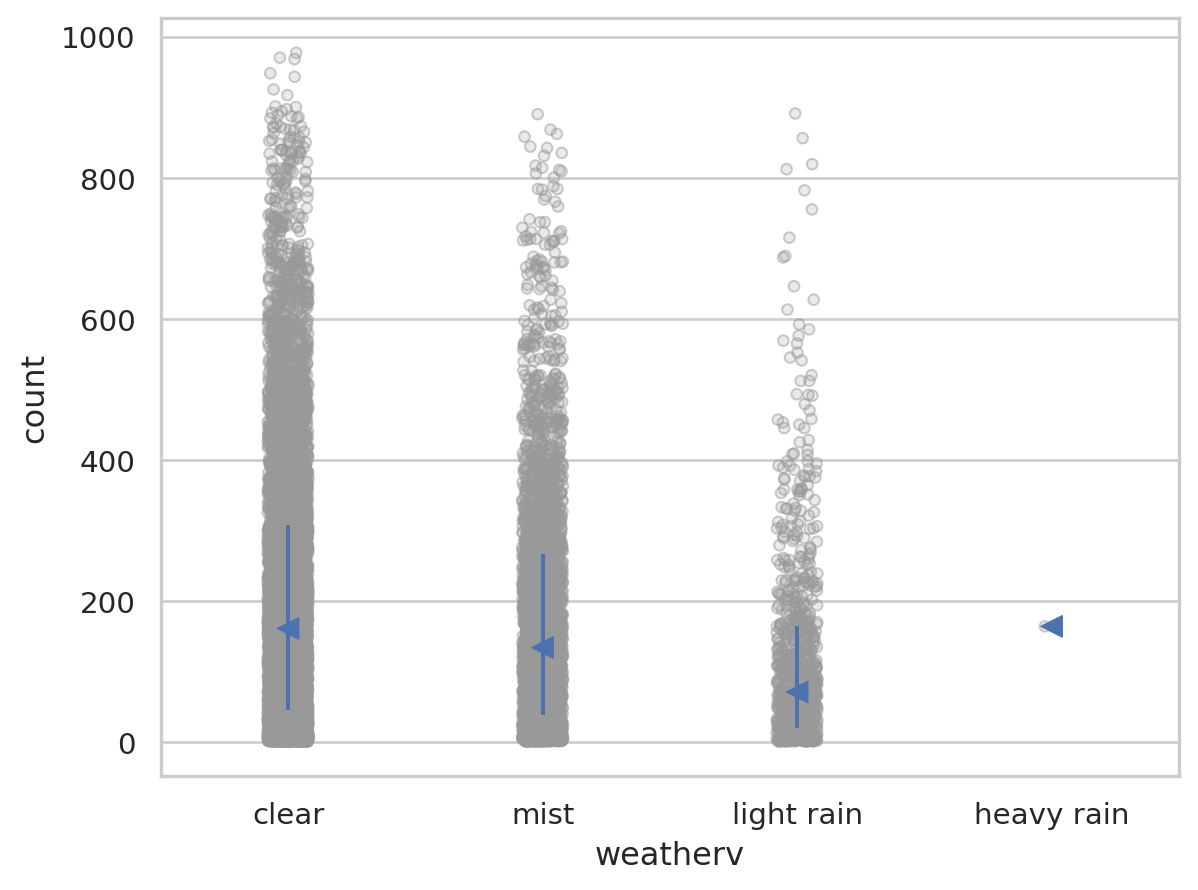

In [502]:
boxplot(bikeshare,'weatherv','count', alpha=.5)

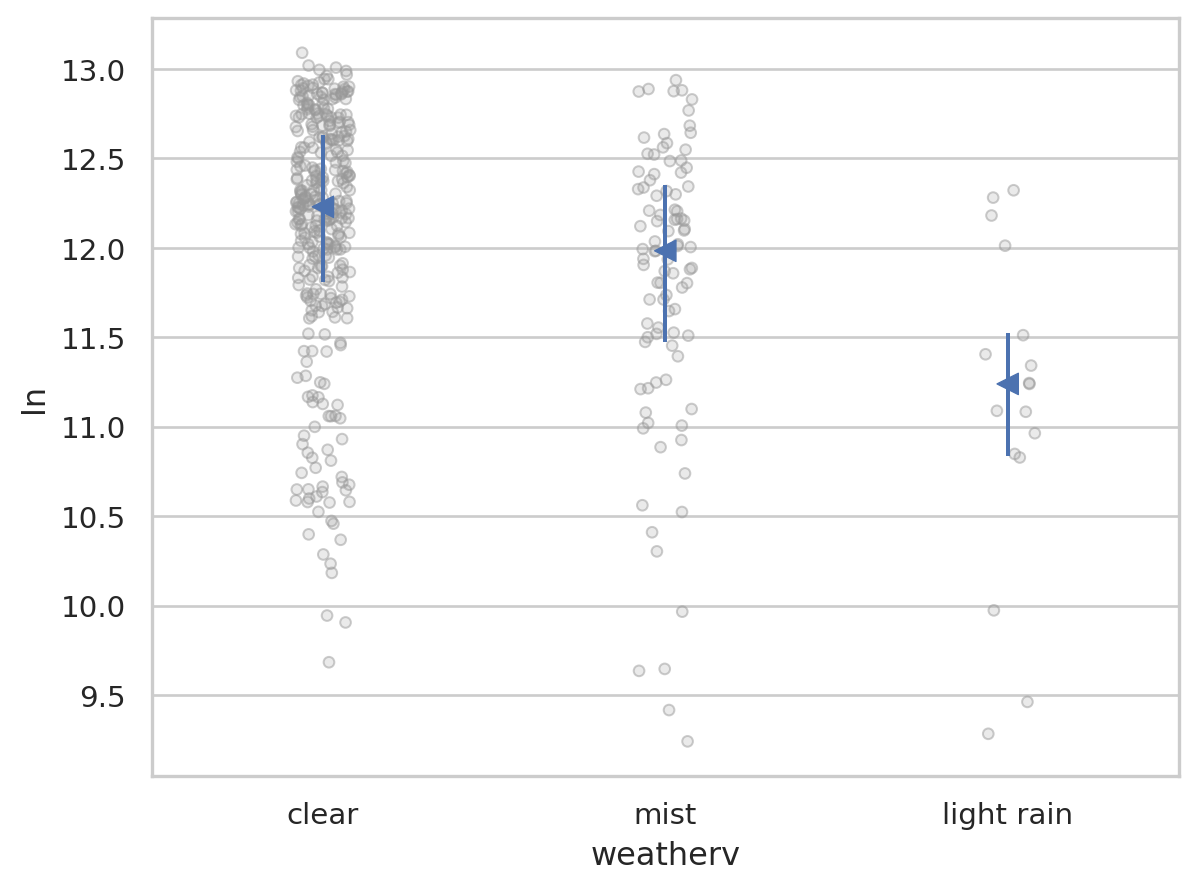

In [503]:
boxplot(daily,'weatherv','ln', alpha=.5)

In [504]:
from statsmodels.formula.api import ols 
# 또는 import statsmodels.formula.api as smf

mod3 = ols("ln ~ weatherv", data=daily).fit()

In [513]:
weatherv = pd.Categorical(
    ['clear', 'light rain', 'mist'],
    categories=[ 'clear', 'light rain', 'mist' ],
)
grid = pd.DataFrame({"weatherv": weatherv})

In [514]:
grid["pred"] = mod3.predict(grid)
grid

daily.groupby("weatherv")["ln"].mean()

weatherv
clear        12.10
light rain   11.12
mist         11.80
Name: ln, dtype: float64

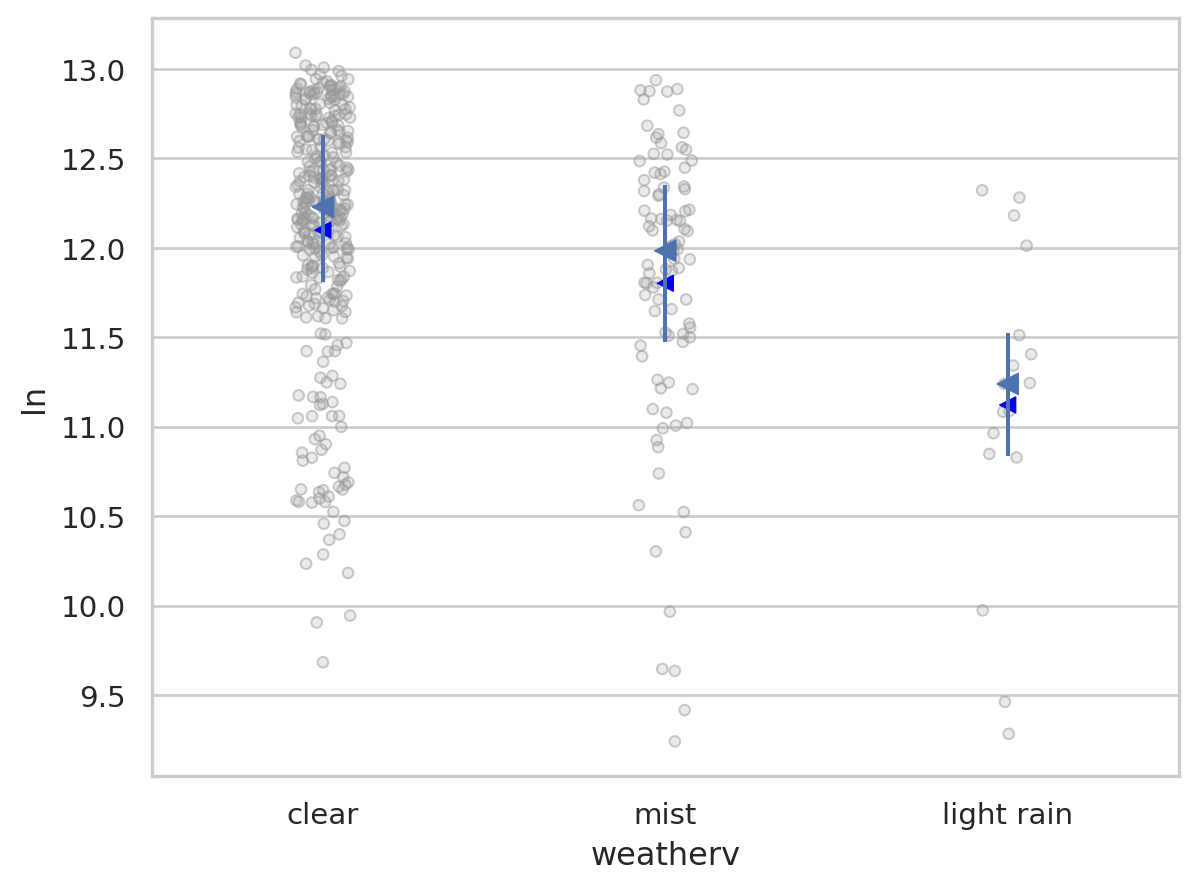

In [515]:
(
    boxplot(daily, "weatherv", "ln", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.weatherv, y=grid.pred)
)

In [516]:
# add a column of residuals from mod
daily["resid"] = mod3.resid

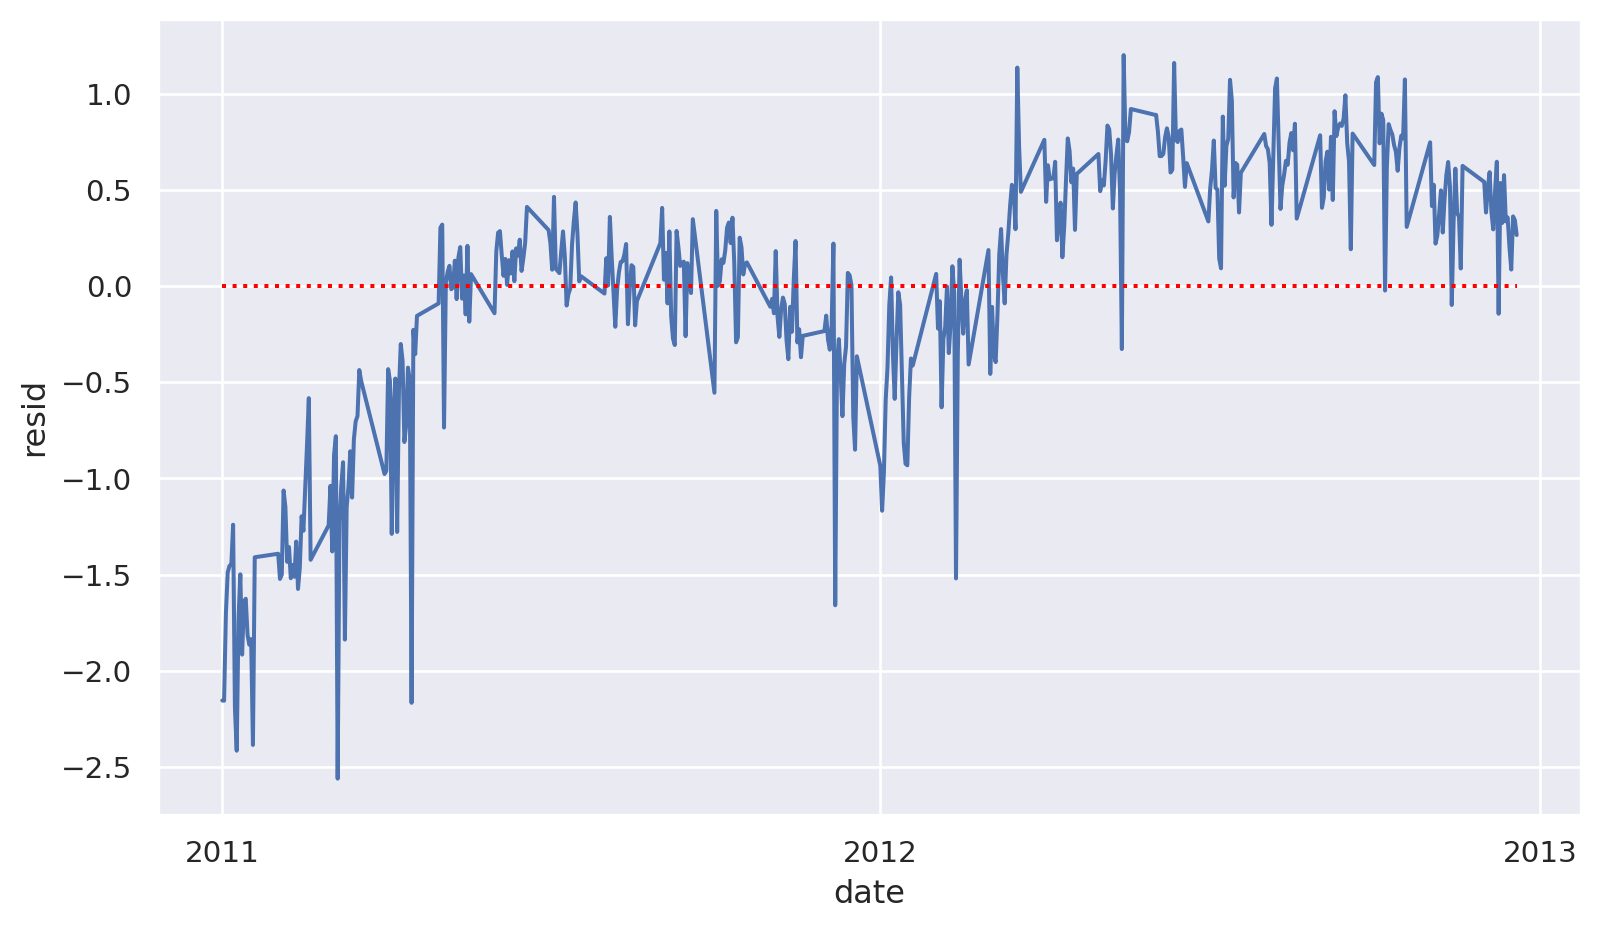

In [517]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

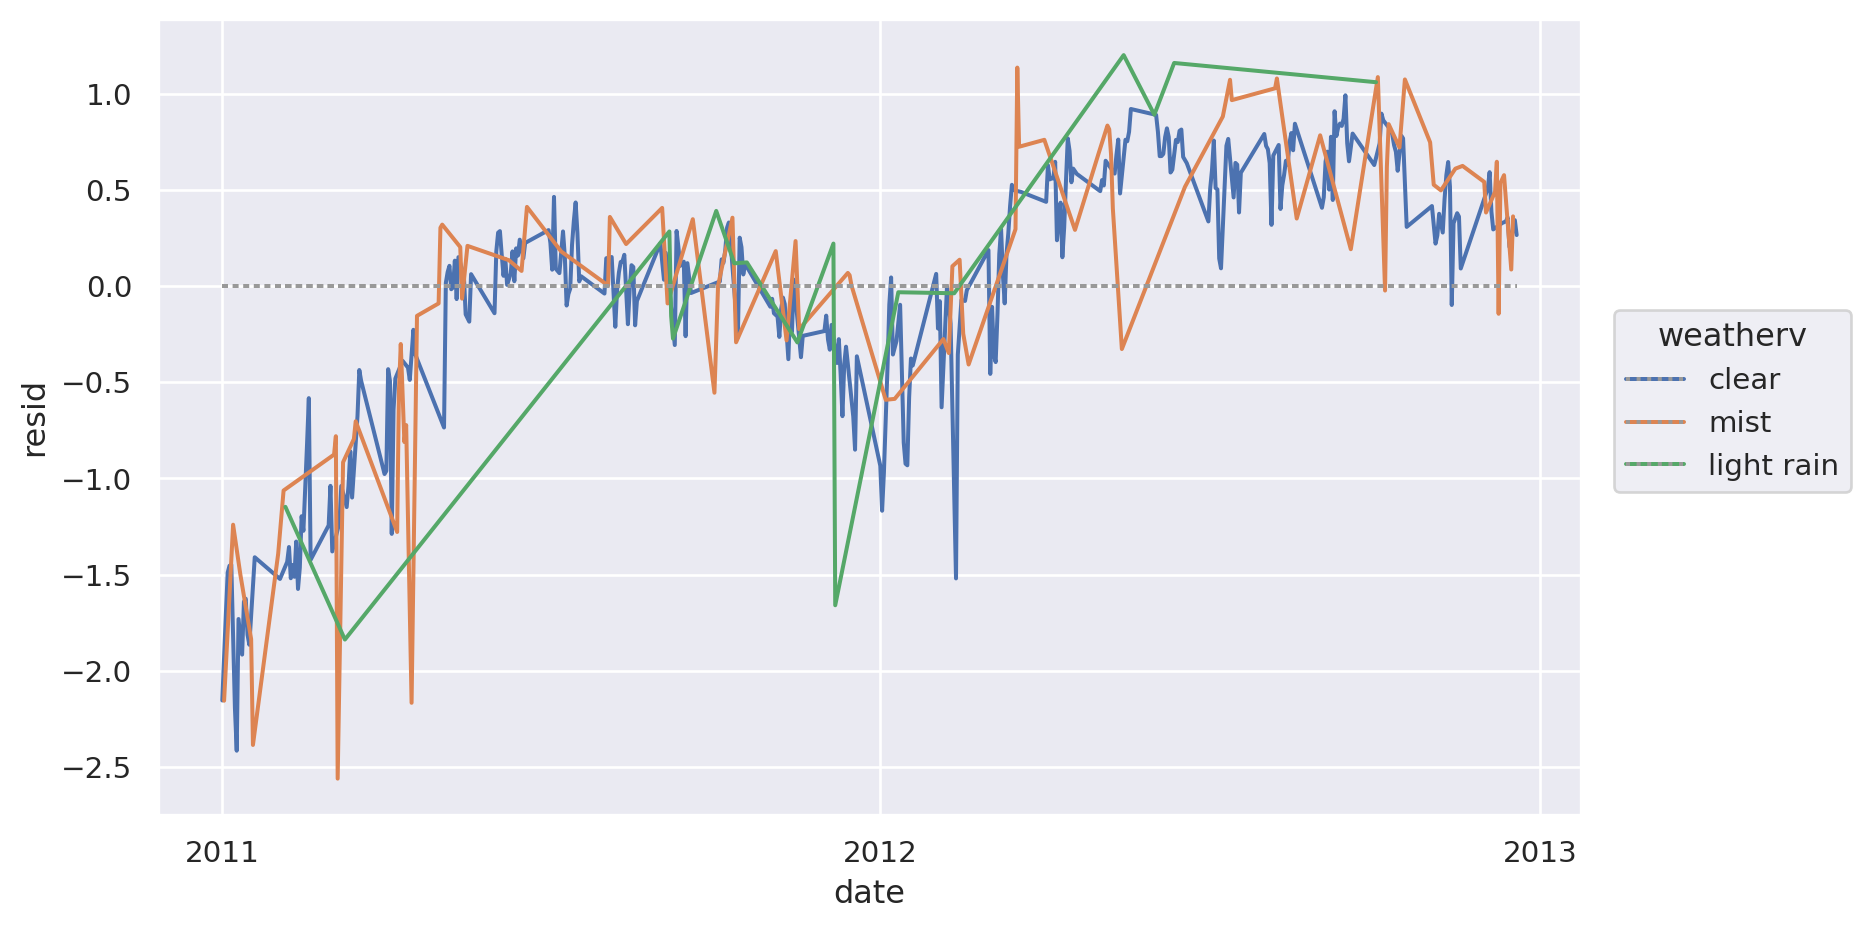

In [518]:
(
    so.Plot(daily, x='date', y='resid', color="weatherv")
    .add(so.Line())
    .add(so.Line(color=".6", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

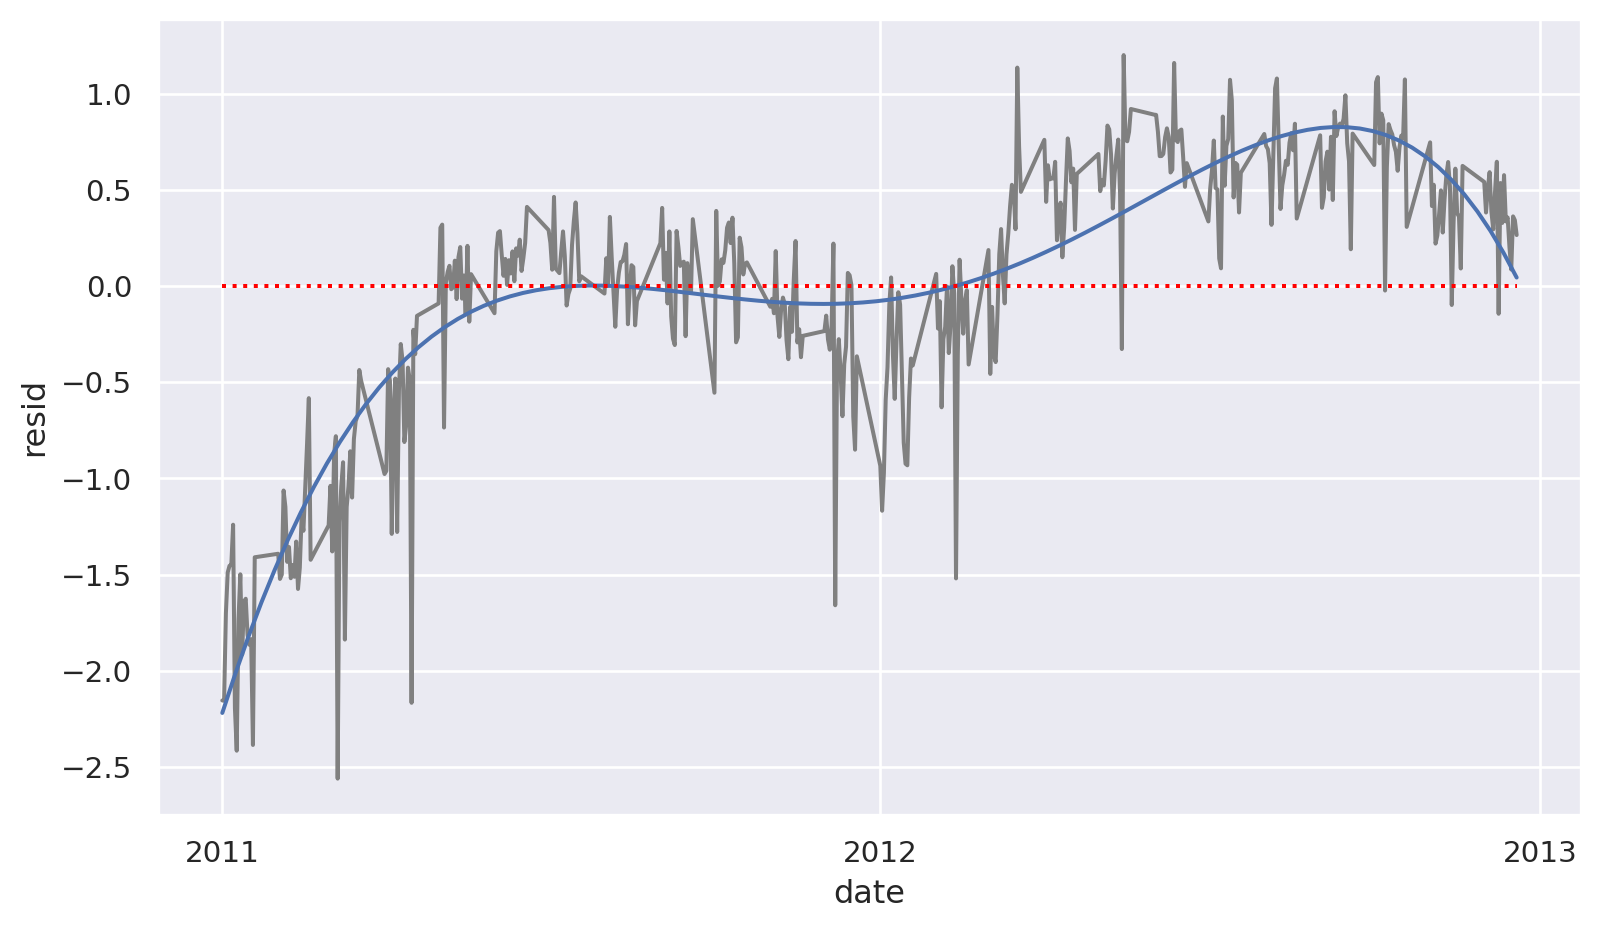

In [519]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line(color=".5"))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8.5, 5))
)

In [520]:
# 일년 중 몇 일째인지 수치형 변수로 추가
daily["day"] = daily["date"].dt.day_of_year
fit_spline = ols("resid ~ cr(day, df=10)", data=daily).fit()
daily["weather_ns_fitted"] = fit_spline.fittedvalues

In [521]:
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["weather_bs_fitted"] = fit_bspline.fittedvalues

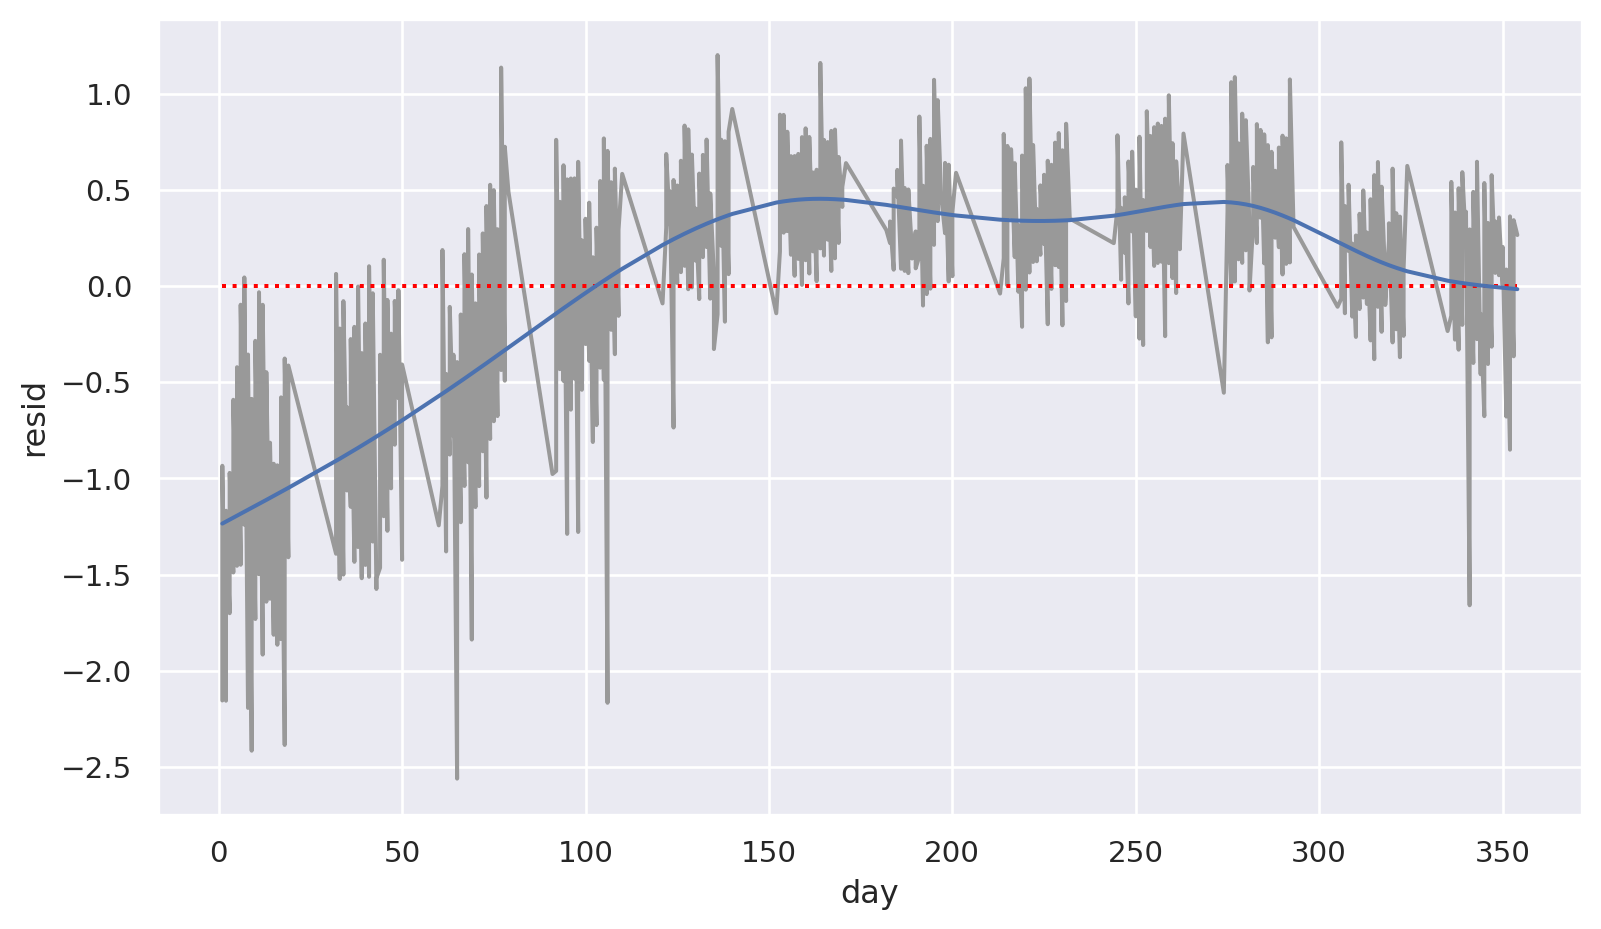

In [522]:
p = (
    so.Plot(daily, x='day', y='resid')
    .add(so.Line(color=".6"))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .add(so.Line(), x=daily.day, y=daily.weather_ns_fitted)  # predicted line by natural spline model
    .layout(size=(8.5, 5))
)
p

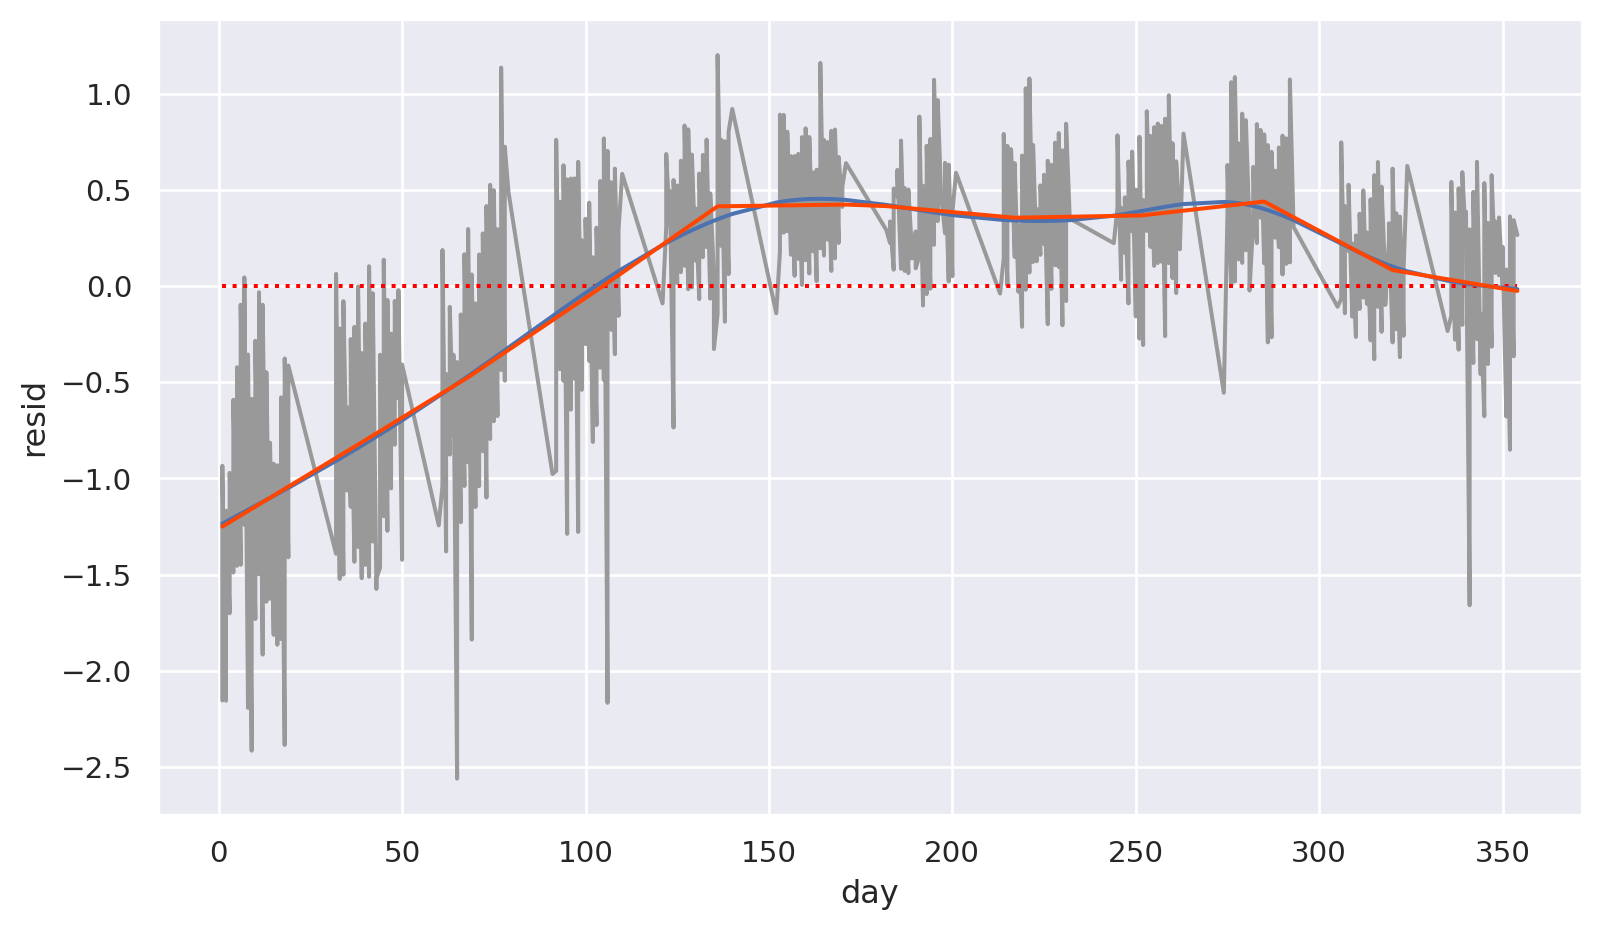

In [523]:
# predicted line by B-spline model
fit_bspline = ols("resid ~ bs(day, df=10, degree=1)", data=daily).fit()
daily["weather_bs_fitted"] = fit_bspline.fittedvalues

p.add(so.Line(color="orangered"), x=daily.day, y=daily.weather_bs_fitted)

---

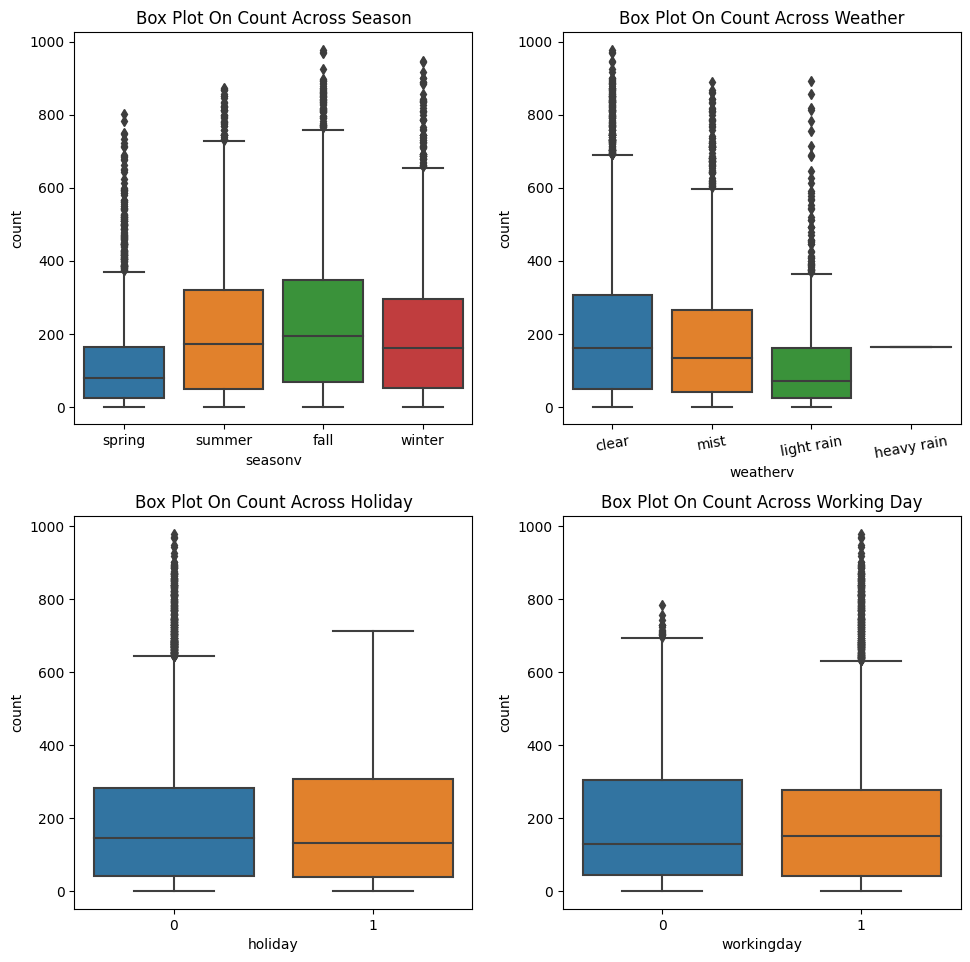

In [524]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='seasonv', y='count', data=bikeshare, ax=axes[0, 0])
sns.boxplot(x='weatherv', y='count', data=bikeshare, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=bikeshare, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=bikeshare, ax=axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0, 1].tick_params('x', labelrotation=10) # 10도 회전

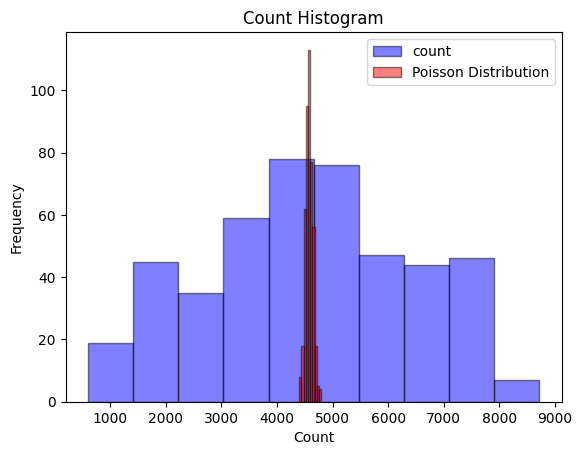

In [419]:
# count 데이터를 히스토그램으로 시각화
plt.hist(daily['n'], bins=10, alpha=0.5, color='blue', edgecolor='black')

# 포아송 분포의 확률 질량 함수를 히스토그램 위에 그리기
poisson_values = np.random.poisson(np.mean(daily['n']), size=len(daily['n']))
plt.hist(poisson_values, bins=10, alpha=0.5, color='red', edgecolor='black')

# 그래프 제목과 축 레이블 설정
plt.title('Count Histogram')
plt.xlabel('Count')
plt.ylabel('Frequency')

# 범례 설정
plt.legend(['count', 'Poisson Distribution'])

# 그래프 출력
plt.show()

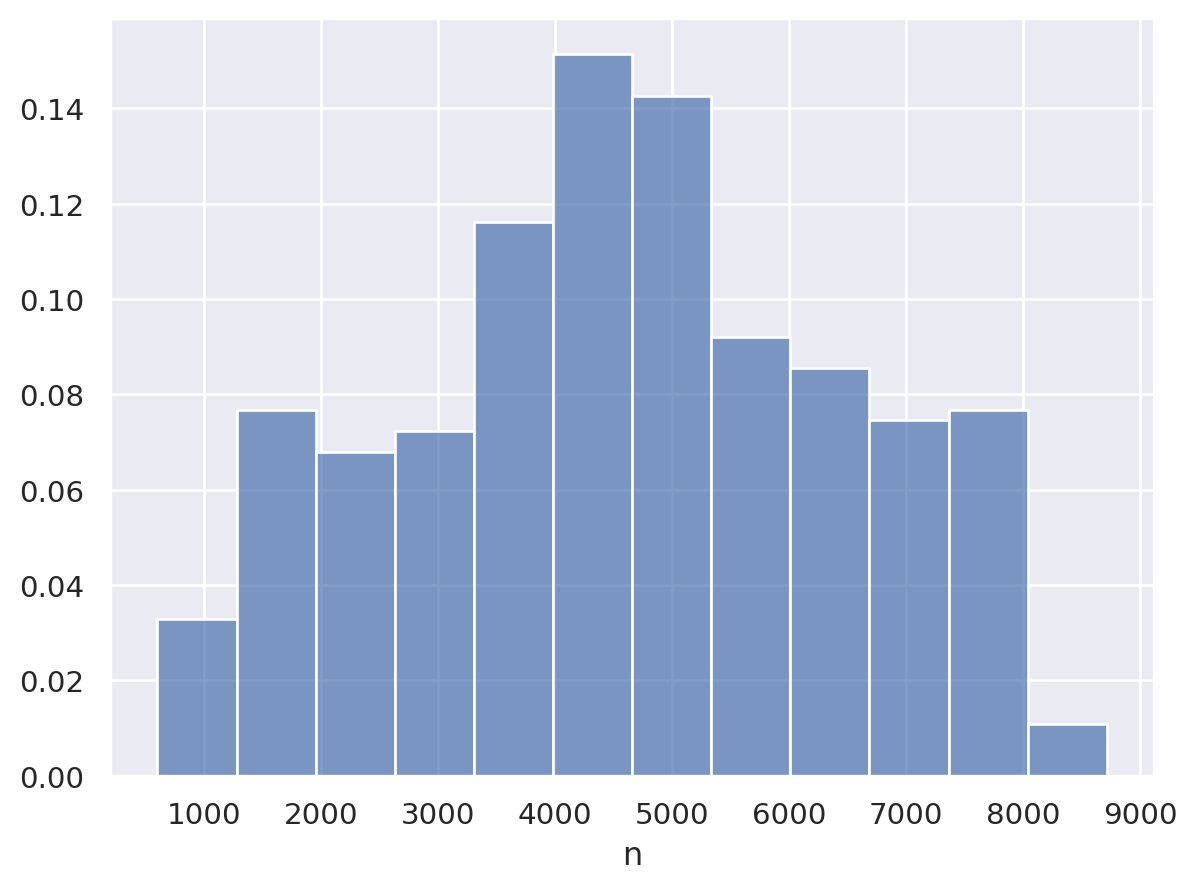

In [421]:
(
    so.Plot(daily, x="n")
    .add(so.Bars(), so.Hist("proportion")) # 비율을 계산; stat="count"가 default
)

In [425]:
# daily['n']의 평균값 계산
mean_value = daily['n'].mean()

# daily['n']의 분산값 계산
variance_value = daily['n'].var()

print("평균값: ", mean_value)
print("분산값: ", variance_value)

평균값:  4573.412280701755
분산값:  3492189.6933873147


In [427]:
# daily['n']의 평균값 계산
mean_value = bikeshare['count'].mean()

# daily['n']의 분산값 계산
variance_value = bikeshare['count'].var()

print("평균값: ", mean_value)
print("분산값: ", variance_value)

평균값:  191.57413191254824
분산값:  32813.31315347235


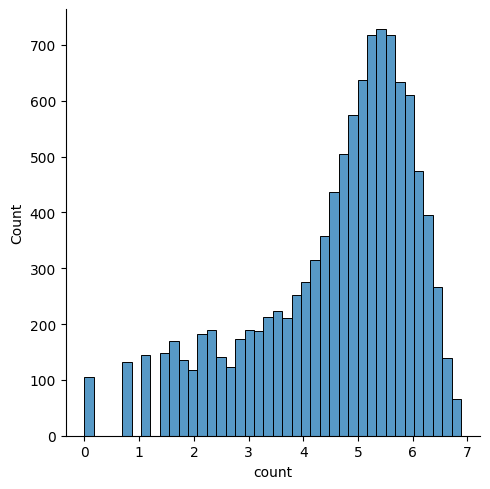

In [447]:
sns.displot(np.log(bikeshare['count']));

In [415]:
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.15    1      -1.19      -1.25       1  spring   
1   2011-01-02   801  Sun  -2.16    2      -1.18      -1.24       1  spring   
2   2011-01-03  1349  Mon  -1.70    3      -1.18      -1.23       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.36  352      -0.06      -0.02       4  winter   
454 2012-12-18  5557  Tue   0.34  353      -0.07      -0.02       4  winter   
455 2012-12-19  5267  Wed   0.26  354      -0.07      -0.03       4  winter   

     most_common_weather weatherv    ln  sason_bs_fitted  season_ns_fitted  \
0                      1    clear  9.94            -0.43             -0.46   
1                      2     mist  9.65            -0.42             -0.45   
2                      1    clear 10.40            -0.41             -0.43   
..                   ...      ...   ...              ...               ...   
453                    2     mist 12.16            -0.21             -0.22   
454                    1    clear 12.44            -0.22             -0.22   
455                    1    clear 12.36            -0.22             -0.23   

     season_bs_fitted  weather_ns_fitted  weather_bs_fitted  
0               -0.43              -1.23              -1.25  
1               -0.42              -1.22              -1.24  
2               -0.41              -1.21              -1.23  
..                ...                ...                ...  
453             -0.21              -0.01              -0.02  
454             -0.22              -0.02              -0.02  
455             -0.22              -0.02              -0.03  

[456 rows x 17 columns]

In [530]:
mod1 = ols("ln ~ wday", data=daily).fit()  # 요일로만 예측

mod2 = ols("ln ~ wday * weatherv", data=daily).fit()

In [531]:
from patsy import dmatrices
y, X = dmatrices("ln ~ wday * weatherv", data=daily, return_type="dataframe")
X.columns

Index(['Intercept', 'wday[T.Mon]', 'wday[T.Tue]', 'wday[T.Wed]', 'wday[T.Thu]',
       'wday[T.Fri]', 'wday[T.Sat]', 'weatherv[T.light rain]',
       'weatherv[T.mist]', 'wday[T.Mon]:weatherv[T.light rain]',
       'wday[T.Tue]:weatherv[T.light rain]',
       'wday[T.Wed]:weatherv[T.light rain]',
       'wday[T.Thu]:weatherv[T.light rain]',
       'wday[T.Fri]:weatherv[T.light rain]',
       'wday[T.Sat]:weatherv[T.light rain]', 'wday[T.Mon]:weatherv[T.mist]',
       'wday[T.Tue]:weatherv[T.mist]', 'wday[T.Wed]:weatherv[T.mist]',
       'wday[T.Thu]:weatherv[T.mist]', 'wday[T.Fri]:weatherv[T.mist]',
       'wday[T.Sat]:weatherv[T.mist]'],
      dtype='object')

In [532]:
daily = daily.assign(
    without_weather = mod1.resid,
    with_weather = mod2.resid,
)

In [533]:
daily

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.15    1      -1.19      -1.25       1  spring   
1   2011-01-02   801  Sun  -2.16    2      -1.18      -1.24       1  spring   
2   2011-01-03  1349  Mon  -1.70    3      -1.18      -1.23       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-12-17  4585  Mon   0.36  352      -0.06      -0.02       4  winter   
454 2012-12-18  5557  Tue   0.34  353      -0.07      -0.02       4  winter   
455 2012-12-19  5267  Wed   0.26  354      -0.07      -0.03       4  winter   

     most_common_weather  ...    ln  sason_bs_fitted  season_ns_fitted  \
0                      1  ...  9.94            -0.43             -0.46   
1                      2  ...  9.65            -0.42             -0.45   
2                      1  ... 10.40            -0.41             -0.43   
..                   ...  ...   ...              ...               ...   
453                    2  ... 12.16            -0.21             -0.22   
454                    1  ... 12.44            -0.22             -0.22   
455                    1  ... 12.36            -0.22             -0.23   

     season_bs_fitted  weather_ns_fitted  weather_bs_fitted  without_season  \
0               -0.43              -1.23              -1.25           -2.15   
1               -0.42              -1.22              -1.24           -2.16   
2               -0.41              -1.21              -1.23           -1.70   
..                ...                ...                ...             ...   
453             -0.21              -0.01              -0.02            0.36   
454             -0.22              -0.02              -0.02            0.34   
455             -0.22              -0.02              -0.03            0.26   

     with_season  without_weather  with_weather  
0          -1.36            -2.06         -2.15  
1          -1.39            -2.26         -1.99  
2          -0.91            -1.63         -1.64  
..           ...              ...           ...  
453         0.03             0.14          0.17  
454         0.20             0.46          0.33  
455         0.12             0.42          0.24  

[456 rows x 21 columns]

In [534]:
daily_models = daily.melt(id_vars=["date"], value_vars=["without_weather", "with_weather"], var_name="model", value_name="residual")

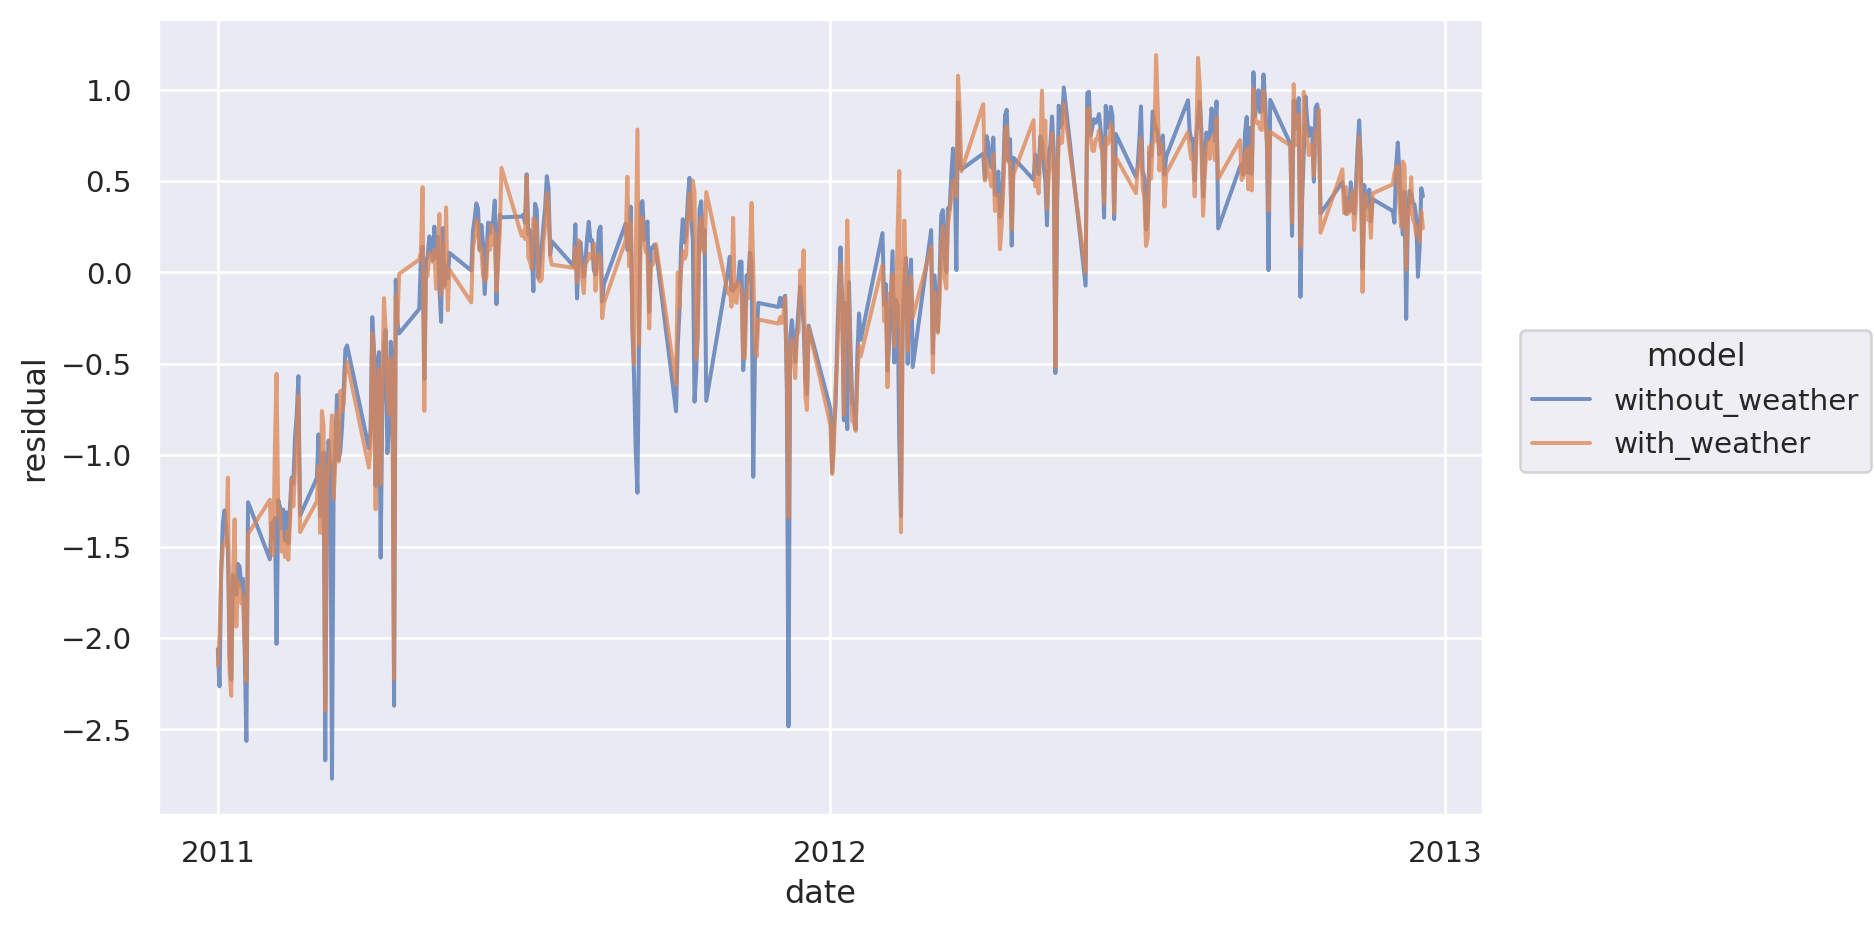

In [535]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line(alpha=.75))
    .layout(size=(8, 5))
)

Interaction이 있는 모델이 약간 나아보이나 좀 더 살펴보고자, 원래의 데이터와 함께 플랏을 그려보면,

In [536]:
wday_grid = np.array(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
weatherv_grid = np.array(["clear","light rain","mist"])

# make a grid of wday and term
from itertools import product
grid = pd.DataFrame(
    list(product(wday_grid, weatherv_grid)),
    columns=["wday", "weatherv"],
)
grid

wday    weatherv
0   Sun       clear
1   Sun  light rain
2   Sun        mist
..  ...         ...
18  Sat       clear
19  Sat  light rain
20  Sat        mist

[21 rows x 2 columns]

In [537]:
grid["pred_mod2"] = mod2.predict(grid[["wday", "weatherv"]])
grid

wday    weatherv  pred_mod2
0   Sun       clear      12.00
1   Sun  light rain      11.51
2   Sun        mist      11.64
..  ...         ...        ...
18  Sat       clear      12.10
19  Sat  light rain      10.53
20  Sat        mist      11.86

[21 rows x 3 columns]

In [538]:
daily_plot = daily.merge(grid)
daily_plot

date     n wday  resid  day  ns_fitted  bs_fitted  season seasonv  \
0   2011-01-01   985  Sat  -2.15    1      -1.19      -1.25       1  spring   
1   2011-01-08   959  Sat  -2.19    8      -1.14      -1.17       1  spring   
2   2011-01-15  1248  Sat  -1.81   15      -1.08      -1.09       1  spring   
..         ...   ...  ...    ...  ...        ...        ...     ...     ...   
453 2012-01-11  2177  Wed  -0.03   11      -1.11      -1.14       1  spring   
454 2011-10-02  2918  Sun   0.39  275       0.38       0.42       4  winter   
455 2012-06-01  4127  Fri   0.89  153       0.44       0.42       2  summer   

     most_common_weather  ... sason_bs_fitted  season_ns_fitted  \
0                      1  ...           -0.43             -0.46   
1                      1  ...           -0.37             -0.37   
2                      1  ...           -0.30             -0.29   
..                   ...  ...             ...               ...   
453                    3  ...           -0.34             -0.34   
454                    3  ...            0.15              0.16   
455                    3  ...            0.17              0.23   

     season_bs_fitted  weather_ns_fitted  weather_bs_fitted  without_season  \
0               -0.43              -1.23              -1.25           -2.15   
1               -0.37              -1.16              -1.17           -2.19   
2               -0.30              -1.09              -1.09           -1.81   
..                ...                ...                ...             ...   
453             -0.34              -1.13              -1.14           -0.03   
454              0.15               0.44               0.42            0.39   
455              0.17               0.44               0.42            0.89   

     with_season  without_weather  with_weather  pred_mod2  
0          -1.36            -2.06         -2.15      12.10  
1          -1.40            -2.10         -2.19      12.10  
2          -1.02            -1.72         -1.81      12.10  
..           ...              ...           ...        ...  
453         0.73            -0.86          0.28      10.80  
454         0.40            -0.40          0.00      11.51  
455        -0.19            -0.07         -0.00      12.01  

[456 rows x 22 columns]

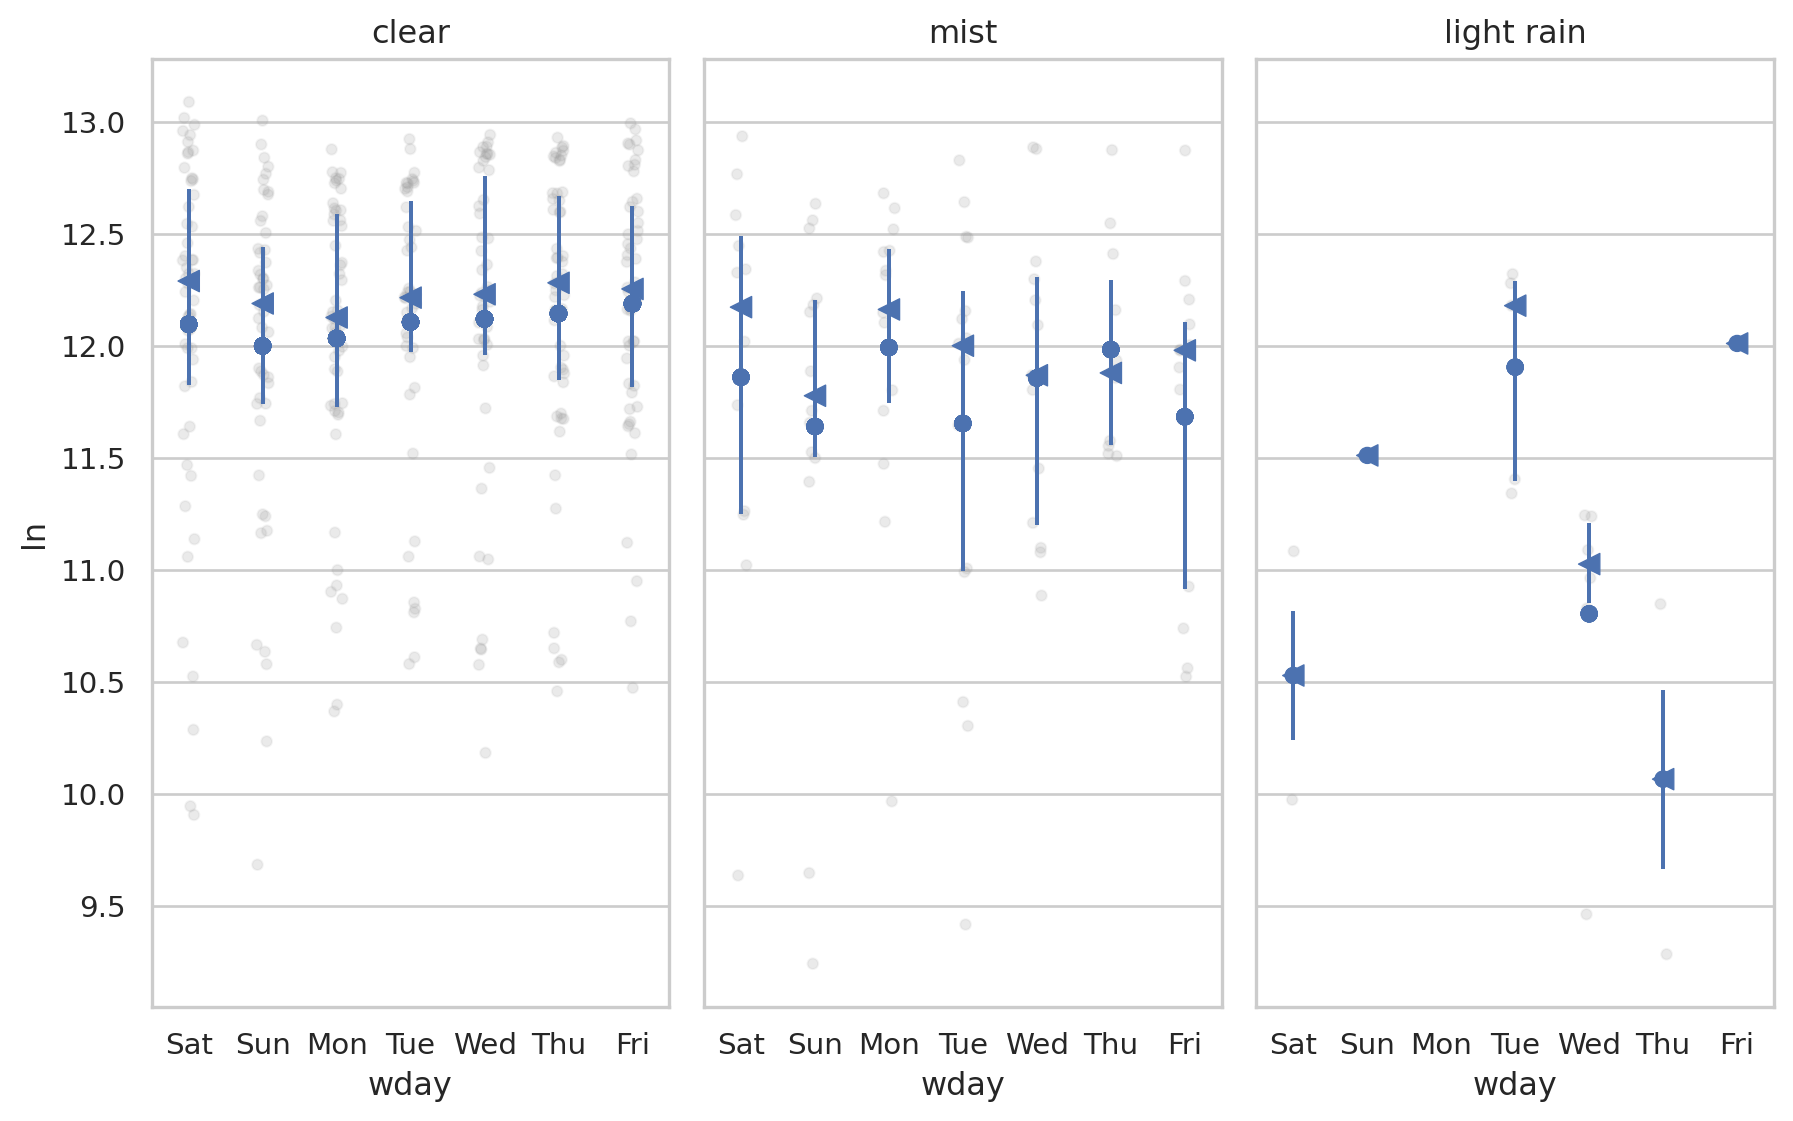

In [540]:
(
    boxplot(daily_plot, x="wday", y="ln")
    .add(so.Dot(), y="pred_mod2")
    .facet("weatherv")
    .layout(size=(9.5, 6))
)

In [541]:
# Robust Linear Model (RLM) in statsmodels
mod3 = sm.RLM.from_formula("ln ~ wday * weatherv", data=daily).fit()

In [542]:
mod3.params

Intercept                      12.10
wday[T.Mon]                     0.02
wday[T.Tue]                     0.10
                                ... 
wday[T.Thu]:weatherv[T.mist]   -0.00
wday[T.Fri]:weatherv[T.mist]   -0.26
wday[T.Sat]:weatherv[T.mist]    0.02
Length: 21, dtype: float64

In [543]:
grid["pred_mod3"] = mod3.predict(grid[["wday", "weatherv"]])
grid

wday    weatherv  pred_mod2  pred_mod3
0   Sun       clear      12.00      12.10
1   Sun  light rain      11.51      11.51
2   Sun        mist      11.64      11.85
..  ...         ...        ...        ...
18  Sat       clear      12.10      12.22
19  Sat  light rain      10.53      10.53
20  Sat        mist      11.86      11.99

[21 rows x 4 columns]

In [544]:
mod3.predict(grid[["wday", "weatherv"]])

0    12.10
1    11.51
2    11.85
      ... 
18   12.22
19   10.53
20   11.99
Length: 21, dtype: float64

In [545]:
# mod2: ols("n ~ wday * weatherv", data=daily)
grid["interaction_ols"] = mod2.predict(grid[["wday", "weatherv"]])

# mod3: robust mod2
grid["interaction_rlm"] = mod3.predict(grid[["wday", "weatherv"]])

In [546]:
daily_median = daily.groupby(["wday", "weatherv"])["ln"].median().reset_index(name="median")

In [547]:
grid = grid.merge(daily_median, on=["wday", "weatherv"])
grid

wday    weatherv  pred_mod2  pred_mod3  interaction_ols  interaction_rlm  \
0   Sun       clear      12.00      12.10            12.00            12.10   
1   Sun  light rain      11.51      11.51            11.51            11.51   
2   Sun        mist      11.64      11.85            11.64            11.85   
..  ...         ...        ...        ...              ...              ...   
18  Sat       clear      12.10      12.22            12.10            12.22   
19  Sat  light rain      10.53      10.53            10.53            10.53   
20  Sat        mist      11.86      11.99            11.86            11.99   

    median  
0    12.19  
1    11.51  
2    11.78  
..     ...  
18   12.29  
19   10.53  
20   12.17  

[21 rows x 7 columns]

In [548]:
grid_long = grid.melt(id_vars=["wday", "weatherv"], value_vars=["interaction_ols", "interaction_rlm", "median"], var_name="model", value_name="ln")
grid_long

wday    weatherv            model    ln
0   Sun       clear  interaction_ols 12.00
1   Sun  light rain  interaction_ols 11.51
2   Sun        mist  interaction_ols 11.64
..  ...         ...              ...   ...
60  Sat       clear           median 12.29
61  Sat  light rain           median 10.53
62  Sat        mist           median 12.17

[63 rows x 4 columns]

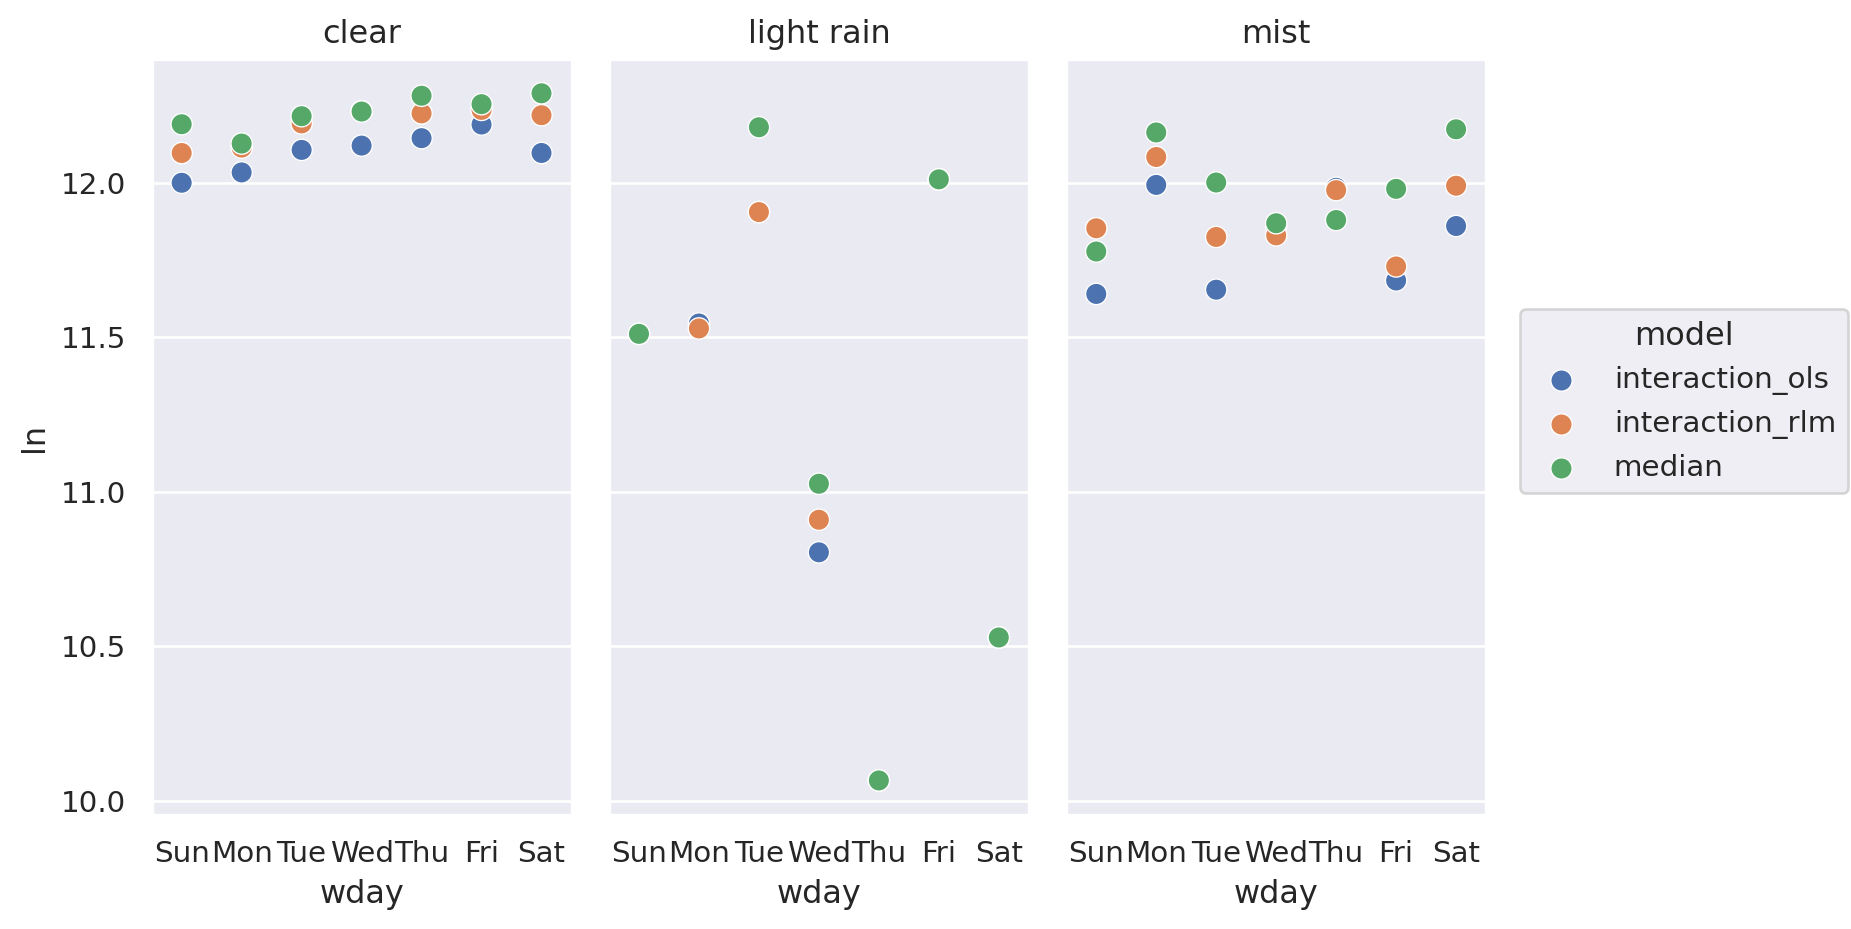

In [550]:
(
    so.Plot(grid_long, x='wday', y='ln', color="model")
    .add(so.Dot(edgecolor="w", pointsize=8))
    .facet("weatherv")
    .layout(size=(8, 5))
)

In [551]:
mod3.params

Intercept                      12.10
wday[T.Mon]                     0.02
wday[T.Tue]                     0.10
                                ... 
wday[T.Thu]:weatherv[T.mist]   -0.00
wday[T.Fri]:weatherv[T.mist]   -0.26
wday[T.Sat]:weatherv[T.mist]    0.02
Length: 21, dtype: float64

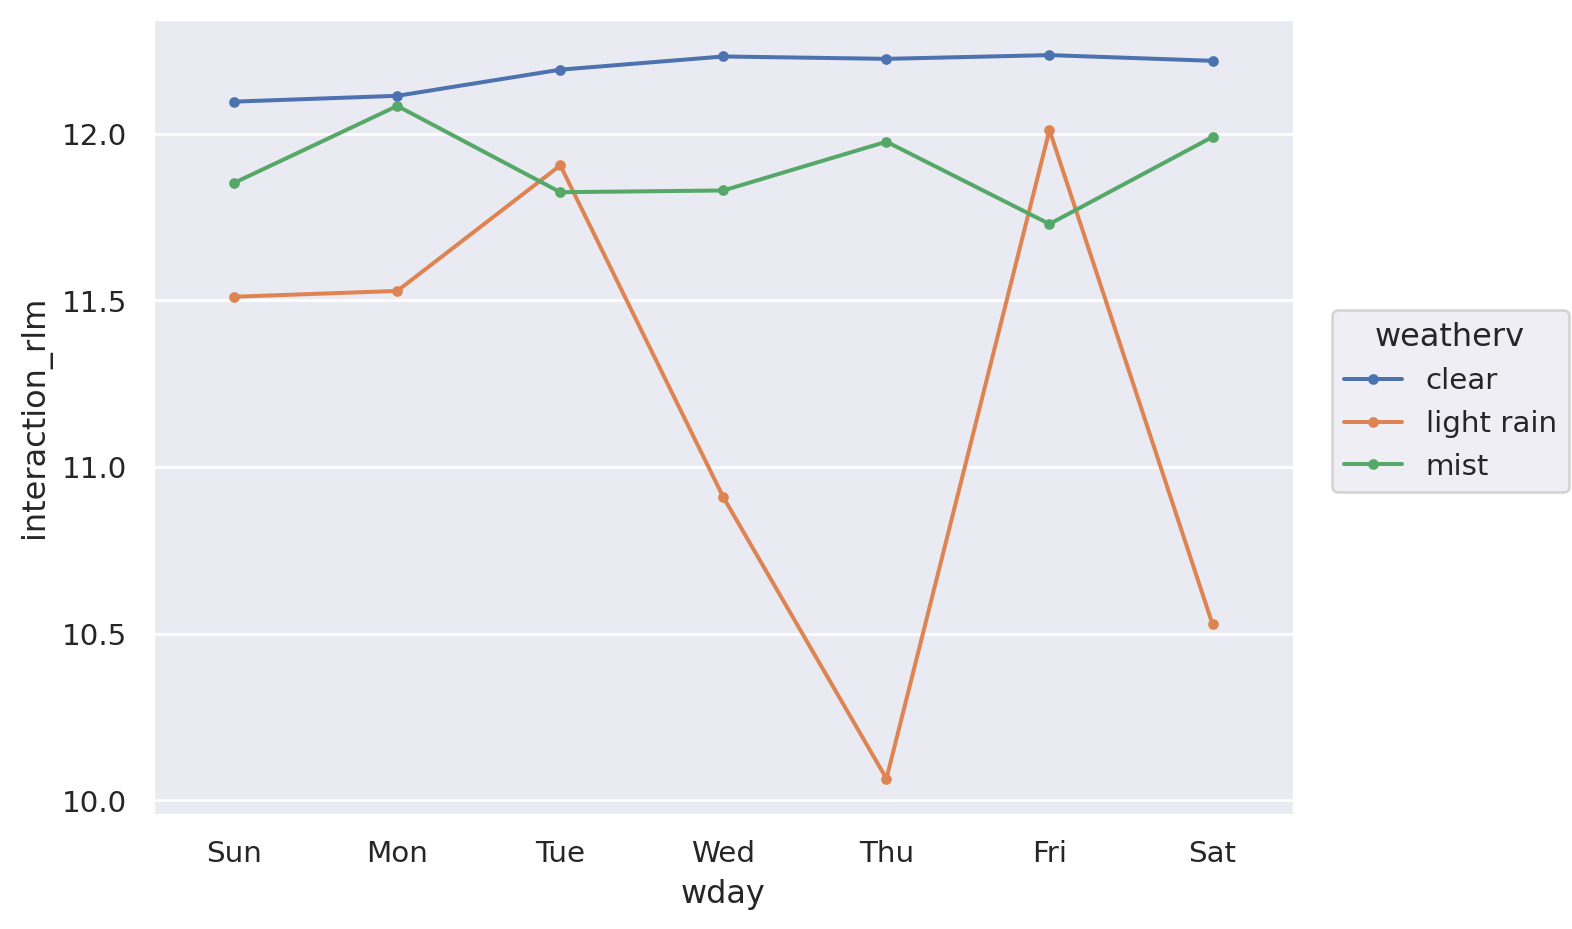

In [552]:
(
    so.Plot(grid, x='wday', y='interaction_rlm', color="weatherv")
    .add(so.Line(marker="."))
    .layout(size=(7, 5))
)

In [560]:
daily["with_weatherv_rlm"] = mod3.resid
daily["with_weatherv"] = mod2.resid

In [561]:
daily_models = daily.melt(
    id_vars=["date"],
    value_vars=["with_weatherv", "with_weatherv_rlm"],
    var_name="model",
    value_name="residual",
)

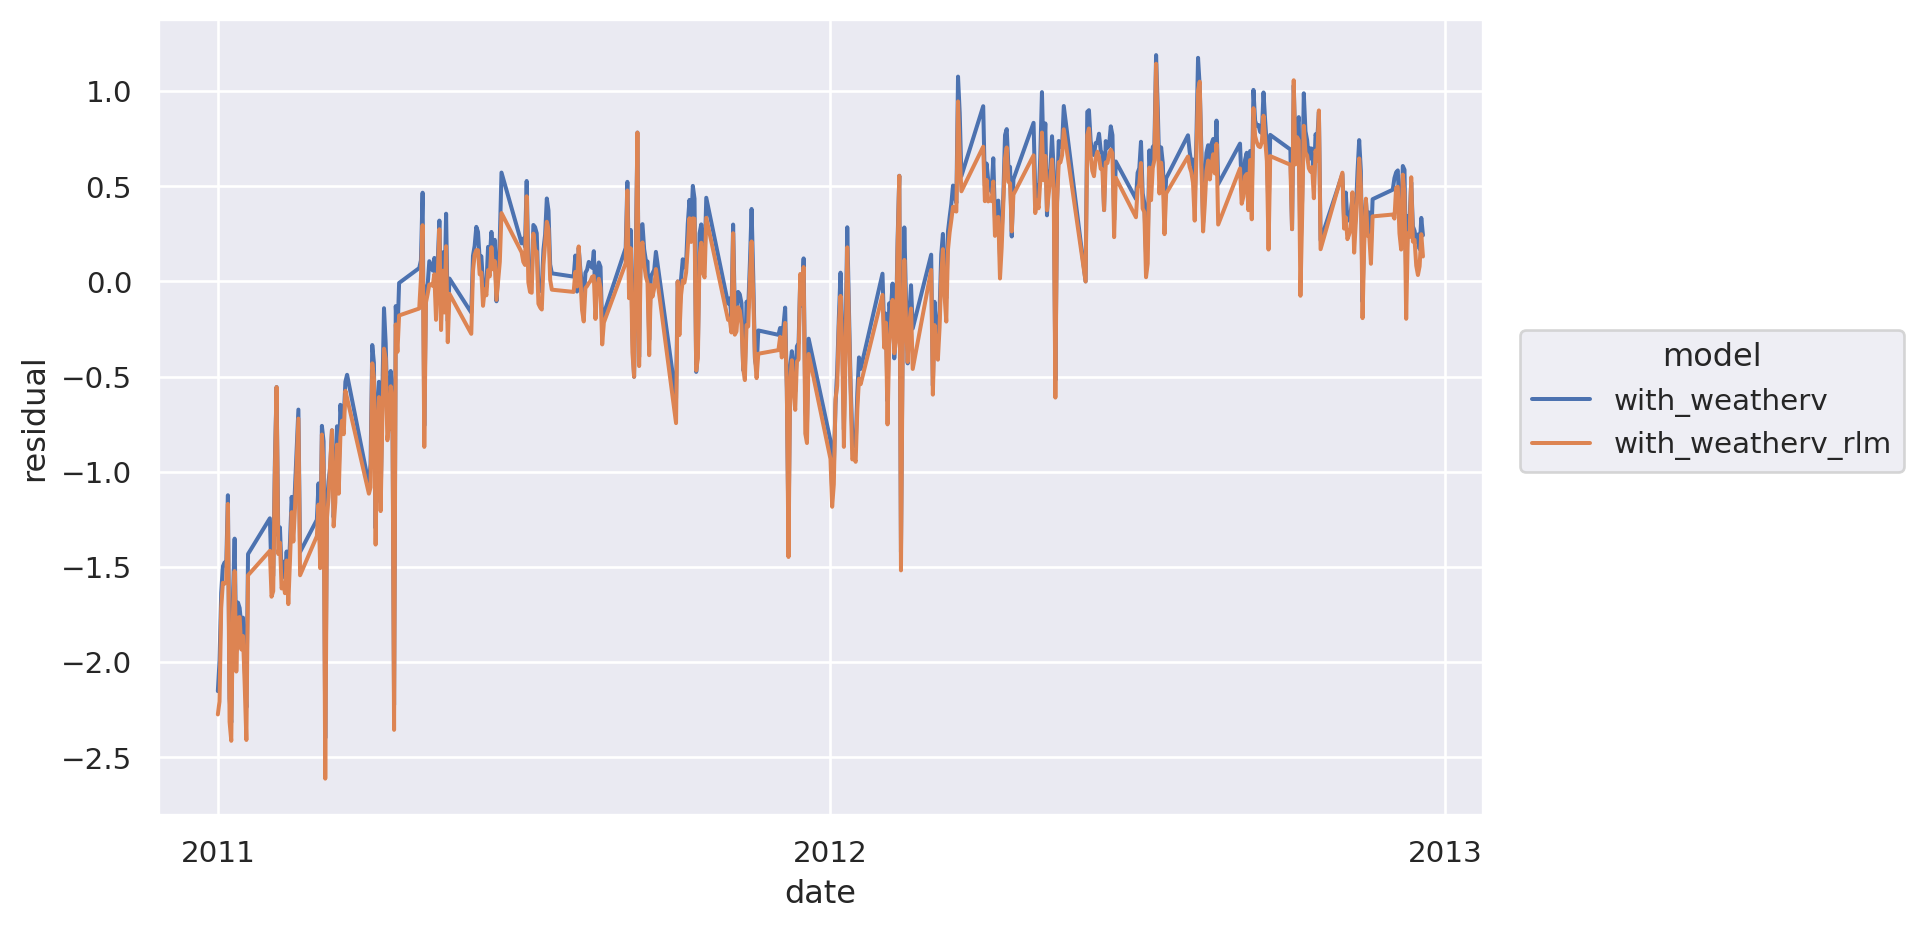

In [562]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line())
    .layout(size=(8, 5))
)